-*- coding: utf-8 -*-
"""
Script pour l'analyse de sentiments sur des données de tweets (Bad Buzz Detection).

Ce script réalise les étapes suivantes :
1. Chargement et analyse exploratoire des données.
2. Nettoyage et prétraitement du texte (lemmatisation, expansion des contractions).
3. Entraînement et évaluation de modèles de classification de texte :
    - Régression Logistique avec TF-IDF.
    - Modèles Keras (CNN, LSTM) avec embeddings pré-entraînés (GloVe).
4. Suivi des expérimentations avec MLflow.
5. Explicabilité des modèles avec LIME et SHAP.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow scikit-learn mlflow gensim shap fasttext lime matplotlib seaborn pandas numpy tqdm

In [ ]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 3.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip show mlflow

Name: mlflow
Version: 3.2.0
Summary: MLflow is an open source platform for the complete machine learning lifecycle
Home-page: https://mlflow.org
Author: 
Author-email: 
License: Copyright 2018 Databricks, Inc.  All rights reserved.

                                Apache License
                           Version 2.0, January 2004
                        http://www.apache.org/licenses/

   TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

   1. Definitions.

      "License" shall mean the terms and conditions for use, reproduction,
      and distribution as defined by Sections 1 through 9 of this document.

      "Licensor" shall mean the copyright owner or entity authorized by
      the copyright owner that is granting the License.

      "Legal Entity" shall mean the union of the acting entity and all
      other entities that control, are controlled by, or are under common
      control with that entity. For the purposes of this definition,
      "control" means (i) the 

In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import warnings
import tensorflow as tf
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import spacy
pd.set_option('display.max_colwidth', 100)
warnings.filterwarnings('ignore')

# Configuration de TensorFlow pour utiliser le GPU s'il est disponible
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"GPU détecté et configuré : {physical_devices[0]}")
else:
    print("Aucun GPU détecté, utilisation du CPU.")

print(tf.config.get_visible_devices())

# Téléchargement des ressources NLTK nécessaires
nltk.download('punkt', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('words', quiet=True)

GPU détecté et configuré : PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

In [ ]:
import warnings
import tensorflow as tf
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import spacy
from spacy.language import Language
from spacy.tokens import Doc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.base import BaseEstimator, TransformerMixin
from wordcloud import WordCloud
from tqdm import tqdm

# Load spaCy model and add custom component once
nlp = spacy.load('en_core_web_lg')

def load_data(data_path):
    """
    Charge les données de tweets à partir du fichier CSV spécifié et affiche les premières lignes.
    Return:
        pd.DataFrame: DataFrame contenant les données des tweets.
    """
    column_names = ["target", "ids", "date", "flag", "user", "text"]
    data = pd.read_csv(data_path, names=column_names, encoding='latin1')
    print("Aperçu des données chargées :")
    print(data.head())
    return data

def analyse_data(data):
    """
    Analyse un DataFrame en affichant le pourcentage de valeurs manquantes, une heatmap des valeurs manquantes,
    le nombre de doublons pour l'ensemble du DataFrame et par colonne. Affiche également des statistiques
    descriptives pour les colonnes numériques et non numériques.

    Args:
        data (pandas.DataFrame): DataFrame à analyser.

    Return:
        None. Cette fonction affiche directement les informations et les graphiques.
    """
    print(data.isna().mean().sort_values())
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.isna())
    print("Nombres de tweets dupliqués : ", data.text.duplicated().sum())
    for col in data.columns:
        n = data[col].duplicated().sum()
        print(f"col = {col} -> duplicated = {n}")
    print("\n")
    print(data.text.duplicated(keep="first"))
    idx = data.text.duplicated(keep="first")
    data.loc[idx, :].sort_values("text").head(10)
    display(data.describe(include=np.number))
    display(data.describe(include=object))

def drop_columns(df):
    """
    Supprime toutes les colonnes sauf 'target' et 'text'.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
    Return:
        pd.DataFrame: DataFrame modifié.
    """
    df = df[['target', 'text']]
    return df

def drop_text_duplicate(df):
    """
    Supprime les tweets en double.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
    Return:
        pd.DataFrame: DataFrame sans doublons.
    """
    df = df.drop_duplicates(subset="text")
    return df

def filter_tweet(df):
    """
    Filtre et supprime les tweets non informatifs et affiche les premières lignes supprimées.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
    Return:
        pd.DataFrame: DataFrame filtré.
    """
    # Drop rows with NaN in 'text' column
    df.dropna(subset=['text'], inplace=True)
    df['text'] = df['text'].str.strip()
    filtered_df = df[df['text'].str.match('^(@\w+\s*)+$')]
    df = df.drop(filtered_df.index, axis= 0)
    display(filtered_df.head(20))
    print(f"Nombre de tweets non informatif supprimés : {filtered_df.shape[0]}")
    return df

def create_sample(df, n_sample):
    """
    Crée un échantillon de tweets positifs et négatifs.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
        n_sample (int): Nombre d'échantillons de chaque sentiment.
    Return:
        pd.DataFrame: DataFrame contenant les échantillons.
    """
    negative_tweets = df[df.iloc[:, 0] == 0]
    negative_tweets = negative_tweets.sample(n = n_sample, random_state=0)
    positive_tweets = df[df.iloc[:, 0] == 4]
    positive_tweets.loc[:,'target'] = positive_tweets['target'].replace({4:1})
    positive_tweets = positive_tweets.sample(n = n_sample, random_state=0)
    df_sample = pd.concat([negative_tweets, positive_tweets], ignore_index=True)
    return df_sample

"""### Preprocessing"""

def expand_contractions(text: str) -> str:
    """
    Étend les contractions dans une chaîne de texte.
    Args:
        text (str): Texte d'entrée.
    Return:
        str: Texte avec contractions étendues.
    """
    flags = re.IGNORECASE | re.MULTILINE

    text = re.sub(r'`', "'", text, flags = flags)

    ## starts / ends with '
    text = re.sub(
        r"(\s|^)'(aight|cause)(\s|$)",
        '\g<1>\g<2>\g<3>',
        text, flags = flags
    )

    text = re.sub(
        r"(\s|^)'t(was|is)(\s|$)", r'\g<1>it \g<2>\g<3>',
        text,
        flags = flags
    )

    text = re.sub(
        r"(\s|^)ol'(\s|$)",
        '\g<1>old\g<2>',
        text, flags = flags
    )

    ## expand words without '
    text = re.sub(r"\b(aight)\b", 'alright', text, flags = flags)
    text = re.sub(r'\bcause\b', 'because', text, flags = flags)
    text = re.sub(r"\b(finna|gonna)\b", 'going to', text, flags = flags)
    text = re.sub(r'\bgimme\b', 'give me', text, flags = flags)
    text = re.sub(r"\bgive'n\b", 'given', text, flags = flags)
    text = re.sub(r"\bhowdy\b", 'how do you do', text, flags = flags)
    text = re.sub(r"\bgotta\b", 'got to', text, flags = flags)
    text = re.sub(r"\binnit\b", 'is it not', text, flags = flags)
    text = re.sub(r"\b(can)(not)\b", r'\g<1> \g<2>', text, flags = flags)
    text = re.sub(r"\bwanna\b", 'want to', text, flags = flags)
    text = re.sub(r"\bmethinks\b", 'me thinks', text, flags = flags)

    ## one offs,
    text = re.sub(r"\bo'er\b", r'over', text, flags = flags)
    text = re.sub(r"\bne'er\b", r'never', text, flags = flags)
    text = re.sub(r"\bo'?clock\b", 'of the clock', text, flags = flags)
    text = re.sub(r"\bma'am\b", 'madam', text, flags = flags)
    text = re.sub(r"\bgiv'n\b", 'given', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\bg'?day\b", 'good day', text, flags = flags)
    text = re.sub(r"\b(ain|amn)'?t\b", 'am not', text, flags = flags)
    text = re.sub(r"\b(are|can)'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(let)'?s\b", r'\g<1> us', text, flags = flags)

    ## major expansions involving smaller,
    text = re.sub(r"\by'all'dn't've'd\b", 'you all would not have had', text, flags = flags)
    text = re.sub(r"\by'all're\b", 'you all are', text, flags = flags)
    text = re.sub(r"\by'all'd've\b", 'you all would have', text, flags = flags)
    text = re.sub(r"(\s)y'all(\s)", r'\g<1>you all\g<2>', text, flags = flags)

    ## minor,
    text = re.sub(r"\b(won)'?t\b", 'will not', text, flags = flags)
    text = re.sub(r"\bhe'd\b", 'he had', text, flags = flags)

    ## major,
    text = re.sub(r"\b(I|we|who)'?d'?ve\b", r'\g<1> would have', text, flags = flags)
    text = re.sub(r"\b(could|would|must|should|would)n'?t'?ve\b", r'\g<1> not have', text, flags = flags)
    text = re.sub(r"\b(he)'?dn'?t'?ve'?d\b", r'\g<1> would not have had', text, flags = flags)
    text = re.sub(r"\b(daren|daresn|dasn)'?t", 'dare not', text, flags = flags)
    text = re.sub(r"\b(he|how|i|it|she|that|there|these|they|we|what|where|which|who|you)'?ll\b", r'\g<1> will', text, flags = flags)
    text = re.sub(r"\b(everybody|everyone|he|how|it|she|somebody|someone|something|that|there|this|what|when|where|which|who|why)'?s\b", r'\g<1> is', text, flags = flags)
    text = re.sub(r"\b(I)'?m'a\b", r'\g<1> am about to', text, flags = flags)
    text = re.sub(r"\b(I)'?m'o\b", r'\g<1> am going to', text, flags = flags)
    text = re.sub(r"\b(I)'?m\b", r'\g<1> am', text, flags = flags)
    text = re.sub(r"\bshan't\b", 'shall not', text, flags = flags)
    text = re.sub(r"\b(are|could|did|does|do|go|had|has|have|is|may|might|must|need|ought|shall|should|was|were|would)n'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(could|had|he|i|may|might|must|should|these|they|those|to|we|what|where|which|who|would|you)'?ve\b", r'\g<1> have', text, flags = flags)
    text = re.sub(r"\b(how|so|that|there|these|they|those|we|what|where|which|who|why|you)'?re\b", r'\g<1> are', text, flags = flags)
    text = re.sub(r"\b(I|it|she|that|there|they|we|which|you)'?d\b", r'\g<1> had', text, flags = flags)
    text = re.sub(r"\b(how|what|where|who|why)'?d\b", r'\g<1> did', text, flags = flags)

    return text

#@Language.factory("expand_contractions")
class ExpandContractionsComponent:
    """
    Composant spaCy pour étendre les contractions dans un document.
    """
    def __init__(self, nlp, name):
        self.nlp = nlp

    def __call__(self, doc: Doc) -> Doc:
        text = doc.text
        text = expand_contractions(text)
        # Returning a new Doc object created from the processed text
        return self.nlp.make_doc(text)


def clean_docs(texts, lemmatize=False, stem=False, rejoin=False):
    """
    Nettoie une liste de documents et optionnellement les lemmatise ou les racinise.

    Args:
        texts (List[str]): Liste de documents.
        lemmatize (bool): Si vrai, lemmatise les tokens.
        stem (bool): Si vrai, racinise les tokens.
        rejoin (bool): Si vrai, rejoint les tokens nettoyés.
    Return:
        List[str]: Documents nettoyés.
    """
    if lemmatize and stem:
        raise ValueError("Un seul transformateur peut être appliqué.")

    def clean_text(text):
        text = re.sub(r'@[A-Za-z0-9_-]{1,15}\b'," ", text)
        text = re.sub(r'https?://[A-Za-z0-9./]+'," ", text)
        text = re.sub(r'&amp;|&quot;', " ", text)
        return text
    texts = [clean_text(text) for text in texts]

    # Use the already loaded nlp model with the custom component in the pipeline
    # Check if the component is already in the pipeline before adding
    if "expand_contractions" not in nlp.pipe_names:
        # Add the component using its registered name
        nlp.add_pipe("expand_contractions", last=True)


    docs = nlp.pipe(texts, disable=['parser', 'ner', 'textcat', 'tok2vec'], batch_size=10_000)
    stemmer = nltk.PorterStemmer()

    docs_cleaned = []
    for doc in docs:
        # The doc.text here will be the text after contractions expansion
        # Now process tokens from this expanded text
        processed_tokens = [token for token in doc if token.is_alpha]
        if lemmatize:
            tokens = [tok.lemma_.strip() for tok in processed_tokens]
        elif stem:
            tokens = [stemmer.stem(tok.text.strip()) for tok in processed_tokens]
        else:
            tokens = [tok.text.strip() for tok in processed_tokens]

        if rejoin:
            tokens = ' '.join(tokens)
        docs_cleaned.append(tokens)

    return docs_cleaned

class SpacyTextCleaner(BaseEstimator, TransformerMixin):
    """
    Transformateur pour nettoyer le texte en utilisant spaCy.
    """
    def __init__(self, lemmatize=False, stem=False, rejoin=False):
        self.lemmatize = lemmatize
        self.stem = stem
        self.rejoin = rejoin

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return clean_docs(X, self.lemmatize, self.stem, self.rejoin)


# WordCloud

def generate_wordcloud(dataframe, column_name, title):
    """
    Génère un nuage de mots à partir d'une colonne d'un DataFrame.
    Args:
        dataframe (pd.DataFrame): DataFrame contenant les données.
        column_name (str): Nom de la colonne contenant le texte.
        title (str): Titre du nuage de mots.
    """
    text = " ".join(review for review in dataframe[column_name].astype(str))
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

def train_valid_test_split(X, y, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=0):
    """
    Sépare les données en ensembles d'entraînement, de validation et de test.
    Args:
        X: Caractéristiques.
        y: Cibles.
        train_size (float): Proportion des données d'entraînement.
        valid_size (float): Proportion des données de validation.
        test_size (float): Proportion des données de test.
        random_state (int): Graine aléatoire pour la reproductibilité.
    Return:
        Tuple: Ensembles d'entraînement, de validation et de test.
    """
    if train_size + valid_size + test_size != 1.0:
        raise ValueError("Les proportions ne s'additionnent pas à 1.0")

    X_train, X_temp, y_train, y_temp = train_test_split(X,
                                                        y,
                                                        stratify=y,
                                                        test_size=1-train_size,
                                                        random_state=random_state)

    relative_test_size = test_size / (valid_size + test_size)

    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp,
                                                        stratify=y_temp,
                                                        test_size=relative_test_size,
                                                        random_state=random_state)

    return X_train, X_valid, X_test, y_train, y_valid, y_test

def calcul_metrics(y_valid, y_valid_pred, y_valid_proba, recover = False):
    """
    Calcule et affiche diverses métriques de classification.
    Args:
        y_valid: Vrais labels de l'ensemble de validation.
        y_valid_pred: Labels prédits pour l'ensemble de validation.
        y_valid_proba: Probabilités prédites pour la classe positive.
        recover (bool): Si vrai, renvoie les scores.
    Return:
        Tuple[float]: Scores si `recover` est vrai.
    """
    print(classification_report(y_valid, y_valid_pred))
    accuracy = accuracy_score(y_valid, y_valid_pred)
    print("Accuracy score :", accuracy)
    precision = precision_score(y_valid, y_valid_pred)
    print("Precision Score :", precision)
    recall = recall_score(y_valid, y_valid_pred)
    print("Recall Score :", recall)
    f1 = f1_score(y_valid, y_valid_pred)
    print("F1 Score :", f1)
    roc_auc = roc_auc_score(y_valid, y_valid_proba)
    print("AUC :" , roc_auc)
    aucpr_score = average_precision_score(y_valid, y_valid_proba)
    print("Average-precision score : ", aucpr_score, "\n")

    if recover:
        return accuracy, precision, recall, f1, roc_auc, aucpr_score

In [ ]:
# Placeholder pour df (votre DataFrame initial)
print("Chargement des données...")
data_path="/content/drive/MyDrive/Colab Notebooks/training.1600000.processed.noemoticon.csv"
#data_path ="training.1600000.processed.noemoticon.csv"
df = load_data(data_path)

Chargement des données...
Aperçu des données chargées :
   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user  \
0  _TheSpecialOne_   
1    scotthamilton   
2         mattycus   
3          ElleCTF   
4           Karoli   

                                                                                                  text  
0  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Thi...  
1  is upset that he can't update his Facebook by texting it... and might cry as a result  School to...  
2            @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds  


In [ ]:
df.shape

(1600000, 6)

In [ ]:
# Afficher les types des colonnes
print("Types des colonnes :")
print(df.dtypes)

# Afficher les statistiques pour toutes les colonnes (numériques et non numériques)
print("\nStatistiques descriptives :")
display(df.describe(include='all'))

Types des colonnes :
target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

Statistiques descriptives :


target           ids                          date      flag  \
count   1.600000e+06  1.600000e+06                       1600000   1600000   
unique           NaN           NaN                        774363         1   
top              NaN           NaN  Mon Jun 15 12:53:14 PDT 2009  NO_QUERY   
freq             NaN           NaN                            20   1600000   
mean    2.000000e+00  1.998818e+09                           NaN       NaN   
std     2.000001e+00  1.935761e+08                           NaN       NaN   
min     0.000000e+00  1.467810e+09                           NaN       NaN   
25%     0.000000e+00  1.956916e+09                           NaN       NaN   
50%     2.000000e+00  2.002102e+09                           NaN       NaN   
75%     4.000000e+00  2.177059e+09                           NaN       NaN   
max     4.000000e+00  2.329206e+09                           NaN       NaN   

            user                       text  
count    1600000                    1600000  
unique    659775                    1581466  
top     lost_dog  isPlayer Has Died! Sorry   
freq         549                        210  
mean         NaN                        NaN  
std          NaN                        NaN  
min          NaN                        NaN  
25%          NaN                        NaN  
50%          NaN                        NaN  
75%          NaN                        NaN  
max          NaN                        NaN

In [ ]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

Nombre moyen de mots par tweet : 13.18


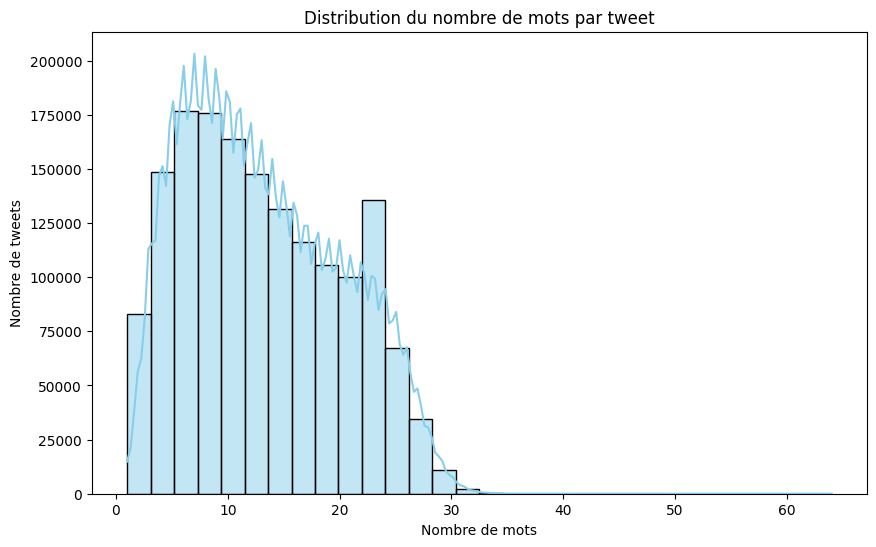

In [ ]:
#Calculer le nombre de mots par tweet
df['nb_mots'] = df['text'].apply(lambda x: len(str(x).split()))

# Afficher la moyenne de mots par tweet
moyenne_mots = df['nb_mots'].mean()
print(f"Nombre moyen de mots par tweet : {moyenne_mots:.2f}")

# Visualiser la distribution du nombre de mots par tweet
plt.figure(figsize=(10,6))
sns.histplot(df['nb_mots'], bins=30, kde=True, color='skyblue')
plt.title('Distribution du nombre de mots par tweet')
plt.xlabel('Nombre de mots')
plt.ylabel('Nombre de tweets')
plt.show()

In [ ]:
min_mots = df['nb_mots'].min()
median_mots = df['nb_mots'].median()
max_mots = df['nb_mots'].max()

print(f"Nombre de mots minimum : {min_mots}")
print(f"Nombre de mots médian : {median_mots}")
print(f"Nombre de mots maximum : {max_mots}")

Nombre de mots minimum : 1
Nombre de mots médian : 12.0
Nombre de mots maximum : 64


In [ ]:
df.head()

target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user  \
0  _TheSpecialOne_   
1    scotthamilton   
2         mattycus   
3          ElleCTF   
4           Karoli   

                                                                                                  text  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Thi...   
1  is upset that he can't update his Facebook by texting it... and might cry as a result  School to...   
2            @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds   
3                                                      my whole body feels itchy and like its on fire    
4  @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you a...   

   nb_mots  
0       19  
1       21  
2       18  
3       10  
4       21

In [ ]:
df.tail()

target         ids                          date      flag  \
1599995       4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996       4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997       4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998       4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999       4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user  \
1599995  AmandaMarie1028   
1599996      TheWDBoards   
1599997           bpbabe   
1599998     tinydiamondz   
1599999   RyanTrevMorris   

                                                                                   text  \
1599995                        Just woke up. Having no school is the best feeling ever    
1599996  TheWDB.com - Very cool to hear old Walt interviews!  â« http://blip.fm/~8bmta   
1599997                       Are you ready for your MoJo Makeover? Ask me for details    
1599998               Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur    
1599999                  happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H    

         nb_mots  
1599995       11  
1599996       11  
1599997       11  
1599998       12  
1599999        5

In [ ]:
# prompt: afficher toute les valeurs de la variable target
print(df['target'].unique())

[0 4]


In [ ]:
df.groupby("target").head()

target         ids                          date      flag  \
0            0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1            0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2            0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3            0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4            0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
800000       4  1467822272  Mon Apr 06 22:22:45 PDT 2009  NO_QUERY   
800001       4  1467822273  Mon Apr 06 22:22:45 PDT 2009  NO_QUERY   
800002       4  1467822283  Mon Apr 06 22:22:46 PDT 2009  NO_QUERY   
800003       4  1467822287  Mon Apr 06 22:22:46 PDT 2009  NO_QUERY   
800004       4  1467822293  Mon Apr 06 22:22:46 PDT 2009  NO_QUERY   

                   user  \
0       _TheSpecialOne_   
1         scotthamilton   
2              mattycus   
3               ElleCTF   
4                Karoli   
800000            ersle   
800001         becca210   
800002        Wingman29   
800003        katarinka   
800004      _EmilyYoung   

                                                                                                       text  \
0       @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Thi...   
1       is upset that he can't update his Facebook by texting it... and might cry as a result  School to...   
2                 @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds   
3                                                           my whole body feels itchy and like its on fire    
4       @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you a...   
800000                                                         I LOVE @Health4UandPets u guys r the best!!    
800001                             im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!   
800002  @DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here i...   
800003  Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make ...   
800004                                                      @LovesBrooklyn2 he has that effect on everyone    

        nb_mots  
0            19  
1            21  
2            18  
3            10  
4            21  
800000        8  
800001       14  
800002       27  
800003       21  
800004        7

Normalisation

In [ ]:
df["target"] = df["target"].replace({0:0, 4:1})
df["target"].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

In [ ]:
df.groupby("target").head()

target         ids                          date      flag  \
0            0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1            0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2            0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3            0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4            0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
800000       1  1467822272  Mon Apr 06 22:22:45 PDT 2009  NO_QUERY   
800001       1  1467822273  Mon Apr 06 22:22:45 PDT 2009  NO_QUERY   
800002       1  1467822283  Mon Apr 06 22:22:46 PDT 2009  NO_QUERY   
800003       1  1467822287  Mon Apr 06 22:22:46 PDT 2009  NO_QUERY   
800004       1  1467822293  Mon Apr 06 22:22:46 PDT 2009  NO_QUERY   

                   user  \
0       _TheSpecialOne_   
1         scotthamilton   
2              mattycus   
3               ElleCTF   
4                Karoli   
800000            ersle   
800001         becca210   
800002        Wingman29   
800003        katarinka   
800004      _EmilyYoung   

                                                                                                       text  \
0       @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Thi...   
1       is upset that he can't update his Facebook by texting it... and might cry as a result  School to...   
2                 @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds   
3                                                           my whole body feels itchy and like its on fire    
4       @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you a...   
800000                                                         I LOVE @Health4UandPets u guys r the best!!    
800001                             im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!   
800002  @DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here i...   
800003  Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make ...   
800004                                                      @LovesBrooklyn2 he has that effect on everyone    

        nb_mots  
0            19  
1            21  
2            18  
3            10  
4            21  
800000        8  
800001       14  
800002       27  
800003       21  
800004        7

=== DÉBUT DE LA DÉTECTION DES FAILLES DU DATAFRAME ===


### 1. Analyse des Valeurs Manquantes ###

--- Résumé Textuel ---
Aucune valeur manquante détectée.


### 2. Analyse des Doublons ###

--- 2.1 Doublons de Lignes ---

--- Résumé Textuel ---
Aucune ligne dupliquée détectée.

--- 2.2 Doublons dans la colonne 'text' ---

--- Résumé Textuel ---
Nombre de doublons dans la colonne 'text': 18534

--- Visualisation ---


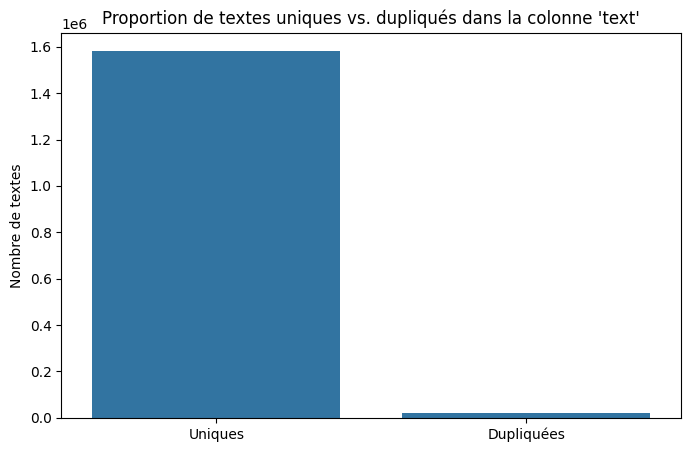



### 3. Analyse de la structure des Colonnes ###

--- 3.1 Colonnes avec une seule valeur unique ---
Colonnes avec une seule valeur unique: ['flag']
Ces colonnes n'apportent généralement pas d'information et peuvent être supprimées.

--- 3.2 Colonnes avec des types de données mixtes ---
Aucune colonne avec des types de données mixtes détectée.

--- 3.3 Distribution des types de données ---

--- Résumé Textuel ---
Répartition des types de données dans le DataFrame:
object    4
int64     3
Name: count, dtype: int64

--- Visualisation ---


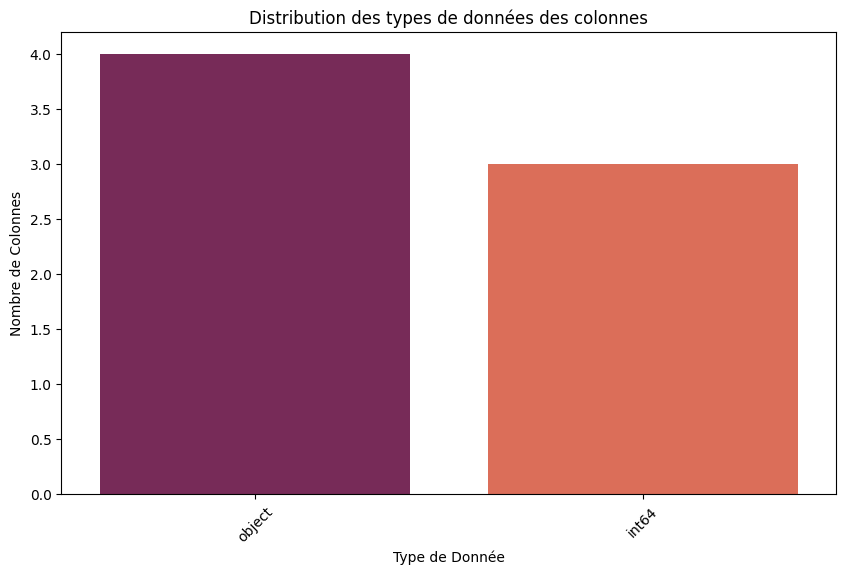


=== FIN DE LA DÉTECTION DES FAILLES DU DATAFRAME ===


Dictionnaire des failles détectées :
{'valeurs_manquantes': {}, 'pourcentage_manquantes': {}, 'doublons_lignes': 0, 'doublons_text': 18534, 'colonnes_single_value': ['flag'], 'colonnes_types_mixtes': []}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def detecter_failles_df(df):
    """
    Détecte et visualise les failles potentielles dans un DataFrame pour le prétraitement.

    Args:
        df (pd.DataFrame): Le DataFrame à analyser.

    Returns:
        dict: Un dictionnaire contenant des informations sur les failles détectées,
              telles que le nombre de valeurs manquantes, les doublons, etc.
    """
    print("===================================================")
    print("=== DÉBUT DE LA DÉTECTION DES FAILLES DU DATAFRAME ===")
    print("===================================================")

    failles = {}

    # --- Section 1: Analyse des Valeurs Manquantes ---
    print("\n\n### 1. Analyse des Valeurs Manquantes ###")
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    failles['valeurs_manquantes'] = missing_values[missing_values > 0].to_dict()
    failles['pourcentage_manquantes'] = missing_percentage[missing_percentage > 0].to_dict()

    print("\n--- Résumé Textuel ---")
    if failles['valeurs_manquantes']:
        print("Valeurs manquantes par colonne:")
        for col, count in failles['valeurs_manquantes'].items():
            print(f"- '{col}': {count} ({failles['pourcentage_manquantes'][col]:.2f}%)")

        # Visualisation
        print("\n--- Visualisation ---")
        plt.figure(figsize=(12, 6))
        missing_df = pd.DataFrame({
            'Colonne': failles['pourcentage_manquantes'].keys(),
            'Pourcentage': failles['pourcentage_manquantes'].values()
        }).sort_values('Pourcentage', ascending=False)

        sns.barplot(x='Pourcentage', y='Colonne', data=missing_df, palette='viridis')
        plt.title('Pourcentage de valeurs manquantes par colonne')
        plt.xlabel('Pourcentage (%)')
        plt.ylabel('Colonnes')
        plt.show()
    else:
        print("Aucune valeur manquante détectée.")

    # --- Section 2: Analyse des Doublons ---
    print("\n\n### 2. Analyse des Doublons ###")

    # Sous-section 2.1: Doublons au niveau des lignes
    print("\n--- 2.1 Doublons de Lignes ---")
    duplicate_rows = df.duplicated().sum()
    failles['doublons_lignes'] = duplicate_rows

    print("\n--- Résumé Textuel ---")
    if duplicate_rows > 0:
        print(f"Nombre total de lignes dupliquées: {duplicate_rows}")

        # Visualisation
        print("\n--- Visualisation ---")
        plt.figure(figsize=(8, 5))
        sns.barplot(x=['Uniques', 'Dupliquées'], y=[len(df) - duplicate_rows, duplicate_rows])
        plt.title('Proportion de lignes uniques vs. dupliquées')
        plt.ylabel('Nombre de lignes')
        plt.show()
    else:
        print("Aucune ligne dupliquée détectée.")

    # Sous-section 2.2: Doublons dans la colonne 'text'
    if 'text' in df.columns:
        print("\n--- 2.2 Doublons dans la colonne 'text' ---")
        duplicate_text = df['text'].duplicated().sum()
        failles['doublons_text'] = duplicate_text

        print("\n--- Résumé Textuel ---")
        if duplicate_text > 0:
            print(f"Nombre de doublons dans la colonne 'text': {duplicate_text}")

            # Visualisation
            print("\n--- Visualisation ---")
            plt.figure(figsize=(8, 5))
            sns.barplot(x=['Uniques', 'Dupliquées'], y=[df['text'].nunique(), duplicate_text])
            plt.title("Proportion de textes uniques vs. dupliqués dans la colonne 'text'")
            plt.ylabel('Nombre de textes')
            plt.show()
        else:
            print("Aucun doublon détecté dans la colonne 'text'.")

    # --- Section 3: Analyse des Colonnes ---
    print("\n\n### 3. Analyse de la structure des Colonnes ###")

    # Sous-section 3.1: Colonnes avec une seule valeur unique
    print("\n--- 3.1 Colonnes avec une seule valeur unique ---")
    failles['colonnes_single_value'] = [col for col in df.columns if df[col].nunique() == 1]

    if failles['colonnes_single_value']:
        print(f"Colonnes avec une seule valeur unique: {failles['colonnes_single_value']}")
        print("Ces colonnes n'apportent généralement pas d'information et peuvent être supprimées.")
    else:
        print("Aucune colonne avec une seule valeur unique détectée.")

    # Sous-section 3.2: Colonnes avec des types de données mixtes
    print("\n--- 3.2 Colonnes avec des types de données mixtes ---")
    failles['colonnes_types_mixtes'] = [
        col for col in df.columns if pd.api.types.infer_dtype(df[col]) == 'mixed'
    ]

    if failles['colonnes_types_mixtes']:
        print(f"Colonnes avec des types de données mixtes: {failles['colonnes_types_mixtes']}")
        print("Ces colonnes peuvent causer des erreurs et nécessitent une investigation.")
    else:
        print("Aucune colonne avec des types de données mixtes détectée.")

    # Sous-section 3.3: Distribution des types de données
    print("\n--- 3.3 Distribution des types de données ---")
    print("\n--- Résumé Textuel ---")
    dtype_counts = df.dtypes.value_counts()
    print("Répartition des types de données dans le DataFrame:")
    print(dtype_counts)

    # Visualisation
    print("\n--- Visualisation ---")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=dtype_counts.index.astype(str), y=dtype_counts.values, palette='rocket')
    plt.title('Distribution des types de données des colonnes')
    plt.xlabel('Type de Donnée')
    plt.ylabel('Nombre de Colonnes')
    plt.xticks(rotation=45)
    plt.show()

    print("\n===================================================")
    print("=== FIN DE LA DÉTECTION DES FAILLES DU DATAFRAME ===")
    print("===================================================")

    return failles

# --- Application ---
# Utilisation de la fonction pour détecter les failles dans le DataFrame de test
failles_detectees = detecter_failles_df(df)

# Vous pouvez toujours inspecter le dictionnaire 'failles_detectees' pour plus de détails
print("\n\nDictionnaire des failles détectées :")
print(failles_detectees)

In [ ]:
def drop_columns(df):
    """
    Supprime toutes les colonnes sauf 'target' et 'text'.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
    Return:
        pd.DataFrame: DataFrame modifié.
    """
    df = df[['target', 'text']]
    return df

def drop_text_duplicate(df):
    """
    Supprime les tweets en double.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
    Return:
        pd.DataFrame: DataFrame sans doublons.
    """
    df = df.drop_duplicates(subset="text")
    return df

def filter_tweet(df):
    """
    Filtre et supprime les tweets non informatifs et affiche les premières lignes supprimées.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
    Return:
        pd.DataFrame: DataFrame filtré.
    """
    df['text'] = df['text'].str.strip()
    filtered_df = df[df['text'].str.match('^(@\w+\s*)+$')]
    df = df.drop(filtered_df.index, axis= 0)
    display(filtered_df.head(20))
    print(f"Nombre de tweets non informatif supprimés : {filtered_df.shape[0]}")
    return df

df = drop_columns(df)
df = drop_text_duplicate(df)
#df = filter_tweet(df)

In [ ]:
type(df)

pandas.core.frame.DataFrame


--- Analyse de l'échantillon de 16 000 observations ---
Dataset équilibré de 16000 échantillons créé.

Statistiques sur le nombre de mots par tweet :
count    16000.000000
mean        13.244250
std          6.941891
min          1.000000
25%          7.000000
50%         12.000000
75%         19.000000
max         33.000000
Name: word_count, dtype: float64


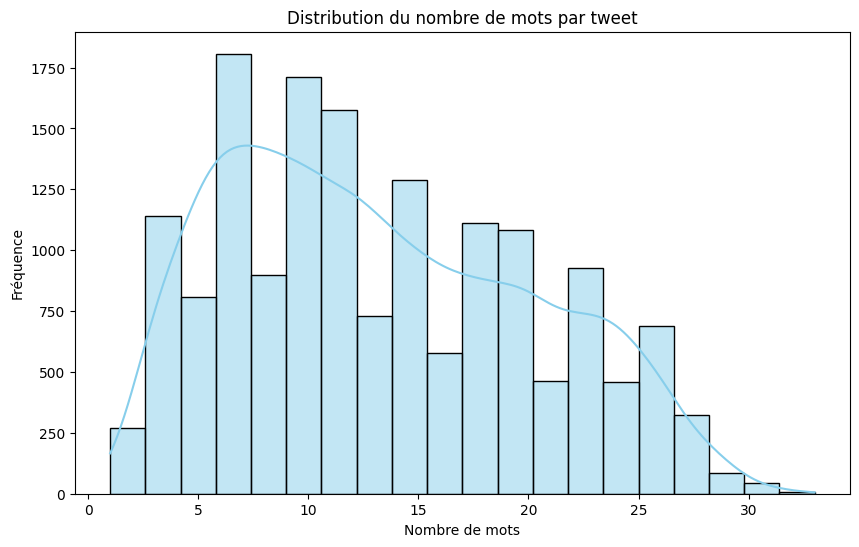

In [ ]:
df_full = df.copy()

# --- Sous-échantillonnage pour obtenir un jeu de données équilibré de 16000 observations ---
df_class_0 = df_full[df_full['target'] == 0].sample(n=8000, random_state=42, replace=True)
df_class_1 = df_full[df_full['target'] == 1].sample(n=8000, random_state=42, replace=True)
df_sampled = pd.concat([df_class_0, df_class_1]).sample(frac=1, random_state=42).reset_index(drop=True)

# --- ANALYSE DE L'ÉCHANTILLON ---
print("\n--- Analyse de l'échantillon de 16 000 observations ---")
print(f"Dataset équilibré de {len(df_sampled)} échantillons créé.")

# Calcul du nombre de mots par tweet
df_sampled['word_count'] = df_sampled['text'].apply(lambda x: len(str(x).split()))

# Statistiques sur le nombre de mots
print("\nStatistiques sur le nombre de mots par tweet :")
print(df_sampled['word_count'].describe())

# Création du graphique de distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_sampled['word_count'], bins=20, kde=True, color='skyblue')
plt.title("Distribution du nombre de mots par tweet")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.show()

In [ ]:
!pip install pyngrok

In [ ]:
from pyngrok import ngrok
# terminate any existing ngrok connections
ngrok.kill()
# setting the token for (optional) authentication
# get your token from https://dashboard.ngrok.com/get-started/your-authtoken
# Authentification avec Ngrok
NGROK_AUTH_TOKEN ="30rGIgggbQUo5LTbfBCAZSMzsg0_4maEijkfe8Zsq5MdLsoRs"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
# Démarrer un tunnel HTTP sur le port 5000 for https://localhost:5000
ngrok_tunnel = ngrok.connect(addr=5000, proto='http', bind_tls=True)
print(f"MLflow Tracking UI:",ngrok_tunnel.public_url)

MLflow Tracking UI: https://291565656f7a.ngrok-free.app


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import tempfile
import time
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split
import mlflow

# Télécharger les ressources NLTK nécessaires si ce n'est pas déjà fait
# essayez de décommenter et d'exécuter la ligne suivante si le code ne fonctionne pas
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialisation des outils de traitement de texte de NLTK
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
# On utilise les stopwords en anglais car l'exemple est en anglais.
# Si vos données sont en français, remplacez par 'french'.
stop_words = set(stopwords.words('english'))

def preprocess_text(text, method="standard"):
    """
    Applique le nettoyage de texte standard, la stemmatisation ou la lemmatisation.
    """
    text = str(text).lower()  # Convertir en minuscules
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Supprimer les caractères non-alphabétiques
    text = text.strip()  # Supprimer les espaces en début et fin de chaîne
    tokens = text.split()

    if method == "stemming":
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    elif method == "lemmatization":
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    else: # Méthode 'standard' par défaut (suppression des stopwords uniquement)
        tokens = [word for word in tokens if word not in stop_words]

    return " ".join(tokens)

def evaluate_bases_logreg_tfidf(bases: dict):
    """
    Évalue chaque base corrigée avec une régression logistique + TF-IDF.
    Affiche les matrices de confusion, les métriques et un tableau récapitulatif.
    Utilise MLflow pour le suivi.
    """
    # Définition du chemin de suivi MLflow
    # Cela créera un dossier 'mlruns_artifacts' dans le répertoire courant
    tracking_uri = "/content/drive/MyDrive/Colab Notebooks/mlruns"
    mlflow.set_tracking_uri(tracking_uri)
    print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")

    results = []
    # Configure l'expérience MLflow
    mlflow.set_experiment("BadBuzz_Base_Selection_LogReg_TFIDF")

    for base_name, base_df in bases.items():
        print(f"\n--- Évaluation de la base : {base_name} ---")

        # Choix de la colonne texte
        text_col = 'text_cleaned' if 'text_cleaned' in base_df.columns else 'text'
        X = base_df[text_col]
        # Remplace la classe 4 (positive) par 1
        y = base_df['target'].replace({4: 1})

        # Split simple train/test (80/20) en s'assurant que la distribution des classes est la même
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        with mlflow.start_run(run_name=f"{base_name}_LogReg_TFIDF"):
            # Initialisation et entraînement du vecteur TF-IDF
            # Amélioration : Ajout de ngram_range=(1, 2) pour capturer le contexte des mots
            vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
            X_train_vec = vectorizer.fit_transform(X_train)
            X_test_vec = vectorizer.transform(X_test)

            # Initialisation et entraînement du modèle de régression logistique
            # Amélioration : Utilisation de class_weight='balanced' pour mieux gérer les déséquilibres de classe,
            # ce qui est essentiel pour améliorer la spécificité de la classe 0 (bad buzz).
            model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')

            # Mesure du temps d'entraînement et d'inférence
            start_time_train = time.time()
            model.fit(X_train_vec, y_train)
            end_time_train = time.time()

            start_time_inference = time.time()
            y_pred = model.predict(X_test_vec)
            end_time_inference = time.time()

            inference_time = end_time_inference - start_time_inference

            # Calcul des métriques
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            cm = confusion_matrix(y_test, y_pred)
            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

            # Calcul de la courbe ROC et de l'AUC
            y_pred_proba = model.predict_proba(X_test_vec)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc_score = auc(fpr, tpr)


            # Enregistrement des métriques et paramètres dans MLflow
            mlflow.log_param("base_name", base_name)
            mlflow.log_metric("accuracy", acc)
            mlflow.log_metric("precision", prec)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("f1_score", f1)
            mlflow.log_metric("specificity", specificity)
            mlflow.log_metric("auc", auc_score)
            mlflow.log_metric("inference_time_sec", inference_time)
            mlflow.log_metric("training_time_sec", end_time_train - start_time_train)

            # Affichage et enregistrement de la matrice de confusion
            plt.figure(figsize=(5,4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
            plt.title(f"Matrice de confusion - {base_name}")
            plt.xlabel("Prédit")
            plt.ylabel("Réel")
            plt.tight_layout()

            with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp_file_cm:
                plt.savefig(tmp_file_cm.name)
                mlflow.log_artifact(tmp_file_cm.name, "confusion_matrix")
            plt.close()

            # Affichage et enregistrement de la courbe ROC
            plt.figure(figsize=(5,4))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic - {base_name}')
            plt.legend(loc="lower right")
            plt.tight_layout()

            with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp_file_roc:
                plt.savefig(tmp_file_roc.name)
                mlflow.log_artifact(tmp_file_roc.name, "roc_curve")
            plt.close()

            print(f"Accuracy: {acc:.4f} | F1-Score: {f1:.4f} | AUC: {auc_score:.4f}")
            print(f"Précision: {prec:.4f} | Recall: {recall:.4f} | Specificité: {specificity:.4f}")
            print(f"Temps d'inférence (test): {inference_time:.4f}s")
            print("Matrice de confusion :\n", cm)

            results.append({
                "Base": base_name,
                "Accuracy": acc,
                "Précision": prec,
                "Recall": recall,
                "F1_score": f1,
                "Specificité": specificity,
                "AUC": auc_score,
                "Inference_Time_sec": inference_time
            })

    # Résumé
    results_df = pd.DataFrame(results)

    # Nouvelle logique pour la meilleure base: spécificité > accuracy
    results_df = results_df.sort_values(by=['Specificité', 'Accuracy'], ascending=[False, False])
    best_idx = results_df.index[0]

    results_df['Meilleure_base'] = ""
    results_df.loc[best_idx, 'Meilleure_base'] = "<-- Meilleure base"
    print("\nRésumé des métriques :")
    print(results_df)

    # Sauvegarde du résumé en tant qu'artefact
    results_csv_path = "summary_results.csv"
    results_df.to_csv(results_csv_path, index=False)
    mlflow.log_artifact(results_csv_path)

    print(f"\nMeilleure base (selon la spécificité puis l'accuracy) : {results_df.loc[best_idx, 'Base']}")
    os.remove(results_csv_path) # Nettoyage du fichier temporaire

# --- Création des données d'exemple et des différentes bases ---
# Créez ici vos données originales
original_df = df_sampled
# Sauvegarde de la base originale
base_originale = original_df.copy()
base_originale['text_cleaned'] = base_originale['text'] # Pour que le code de la fonction l'utilise
base_originale.rename(columns={'text': 'text_uncleaned'}, inplace=True) # Renomme l'originale pour éviter la confusion

# Création de la base avec nettoyage standard
base_nettoyage_standard = original_df.copy()
base_nettoyage_standard['text_cleaned'] = base_nettoyage_standard['text'].apply(lambda x: preprocess_text(x, "standard"))

# Création de la base avec nettoyage + stemmatisation
base_stemming = original_df.copy()
base_stemming['text_cleaned'] = base_stemming['text'].apply(lambda x: preprocess_text(x, "stemming"))

# Création de la base avec nettoyage + lemmatisation
base_lemmatisation = original_df.copy()
base_lemmatisation['text_cleaned'] = base_lemmatisation['text'].apply(lambda x: preprocess_text(x, "lemmatization"))

# Le dictionnaire 'Bases' que la fonction attend
Bases = {
    'Base_Originale': base_originale,
    'Nettoyage_Standard': base_nettoyage_standard,
    'Stemmatisation': base_stemming,
    'Lemmatisation': base_lemmatisation
}

# Appel de la fonction avec les nouvelles données
evaluate_bases_logreg_tfidf(Bases)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


MLflow tracking URI: /content/drive/MyDrive/Colab Notebooks/mlruns

--- Évaluation de la base : Base_Originale ---
Accuracy: 0.7600 | F1-Score: 0.7630 | AUC: 0.8428
Précision: 0.7537 | Recall: 0.7725 | Specificité: 0.7475
Temps d'inférence (test): 0.0004s
Matrice de confusion :
 [[1196  404]
 [ 364 1236]]

--- Évaluation de la base : Nettoyage_Standard ---
Accuracy: 0.7431 | F1-Score: 0.7475 | AUC: 0.8251
Précision: 0.7349 | Recall: 0.7606 | Specificité: 0.7256
Temps d'inférence (test): 0.0005s
Matrice de confusion :
 [[1161  439]
 [ 383 1217]]

--- Évaluation de la base : Stemmatisation ---
Accuracy: 0.7584 | F1-Score: 0.7640 | AUC: 0.8290
Précision: 0.7469 | Recall: 0.7819 | Specificité: 0.7350
Temps d'inférence (test): 0.0003s
Matrice de confusion :
 [[1176  424]
 [ 349 1251]]

--- Évaluation de la base : Lemmatisation ---
Accuracy: 0.7472 | F1-Score: 0.7513 | AUC: 0.8276
Précision: 0.7393 | Recall: 0.7638 | Specificité: 0.7306
Temps d'inférence (test): 0.0005s
Matrice de confusion 

In [ ]:
mlflow.end_run()

In [ ]:
print(Bases.keys())

dict_keys(['Base_Originale', 'Nettoyage_Standard', 'Stemmatisation', 'Lemmatisation'])



--- Analyse de l'échantillon de 16 000 observations ---

Statistiques sur le nombre de mots par tweet :
count    16000.000000
mean        13.244250
std          6.941891
min          1.000000
25%          7.000000
50%         12.000000
75%         19.000000
max         33.000000
Name: word_count, dtype: float64


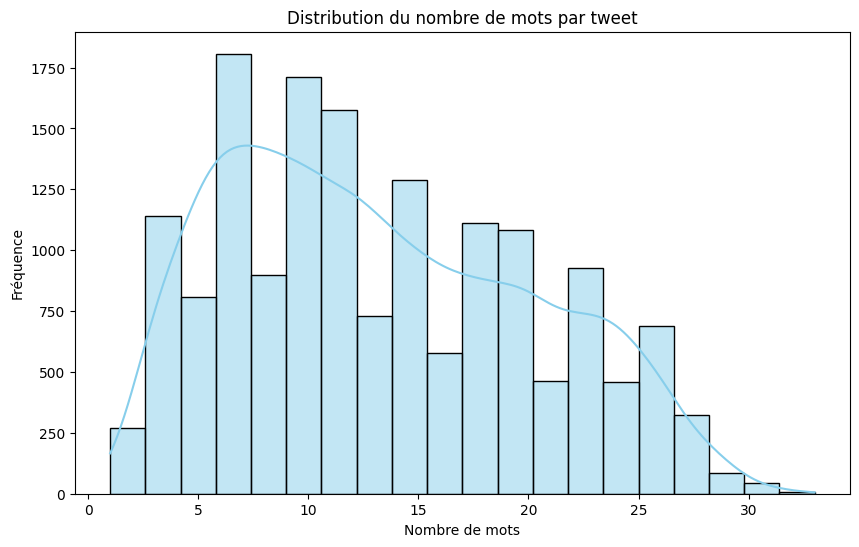


--- Génération des nuages de mots ---


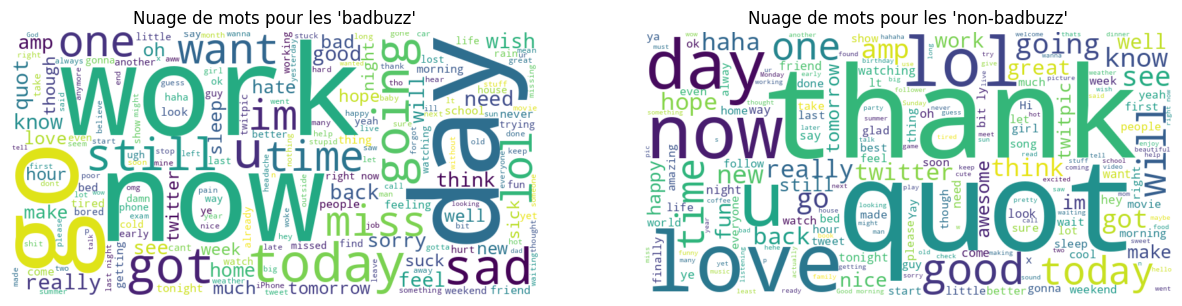


--- Entraînement des modèles ---
-> Modèle: LR + TFIDF


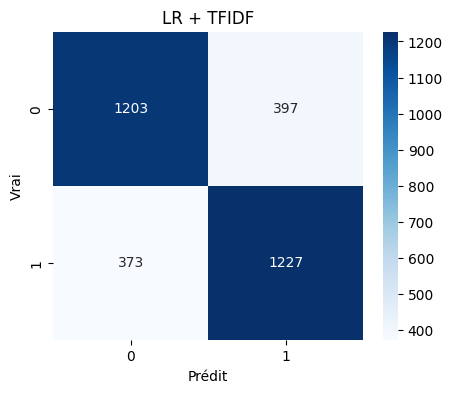

Tokenizer enregistré à : /content/drive/MyDrive/Colab Notebooks/saved_model/lstm/tokenizer.pkl

Chargement du modèle FastText en anglais (cc.en.300.bin)...

-> Modèle: Keras + GloVe (sans LSTM)
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


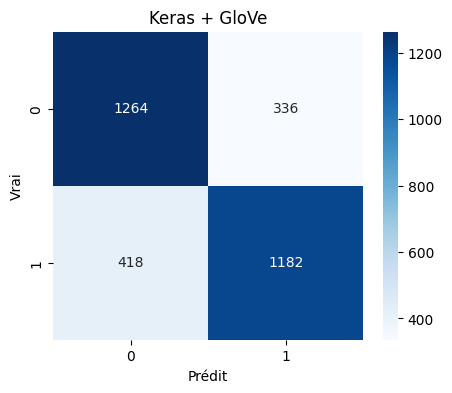

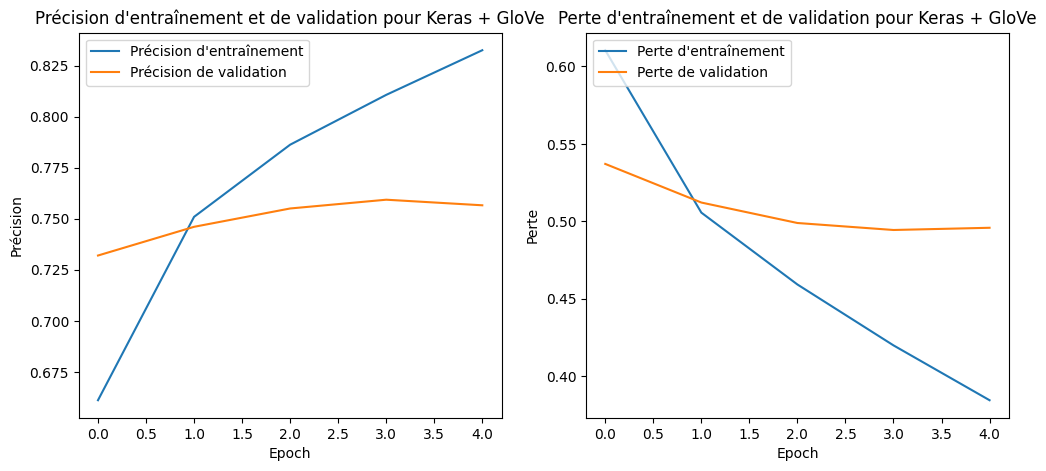

2025/08/14 14:41:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/14 14:41:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



-> Modèle: Keras + Word2Vec (sans LSTM)
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


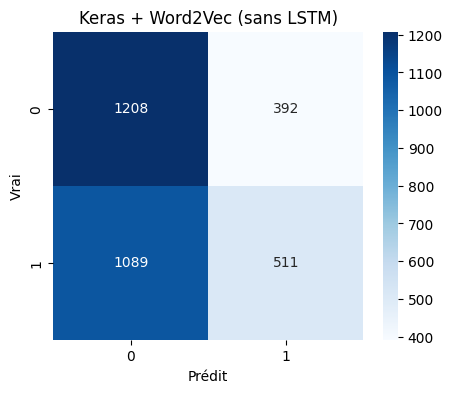

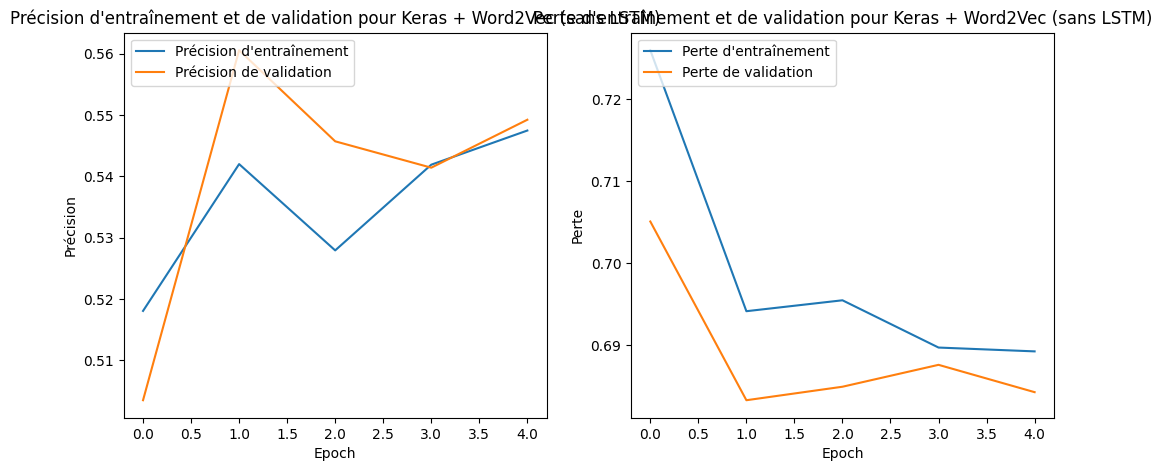

2025/08/14 14:41:48 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/14 14:41:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



-> Modèle: Keras + FastText (sans LSTM)
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


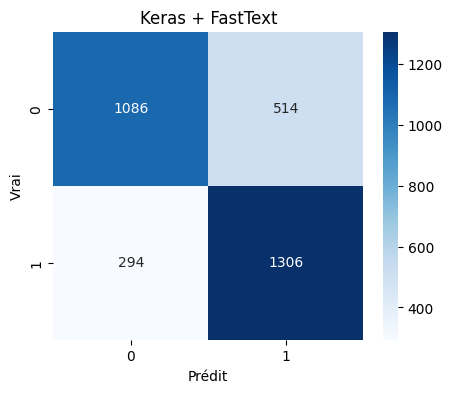

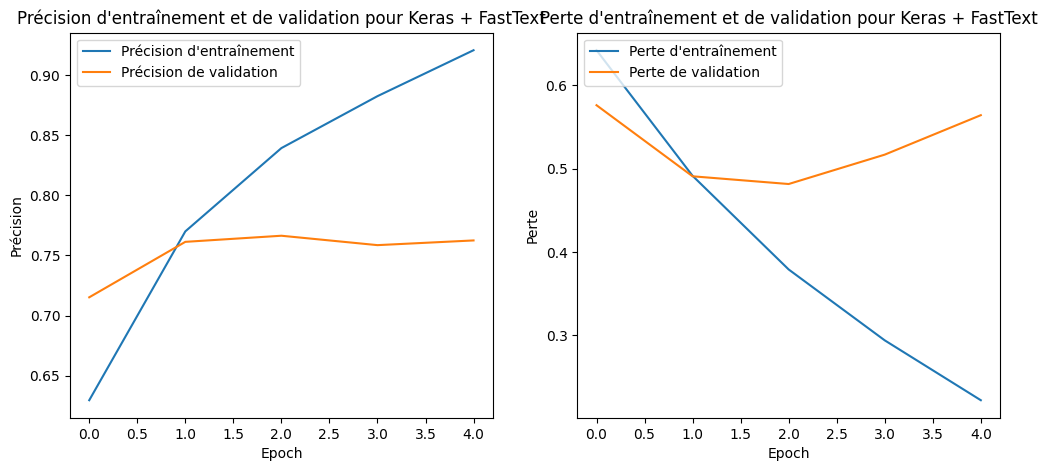

2025/08/14 14:42:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/14 14:42:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



-> Modèle: Keras + GloVe + LSTM
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


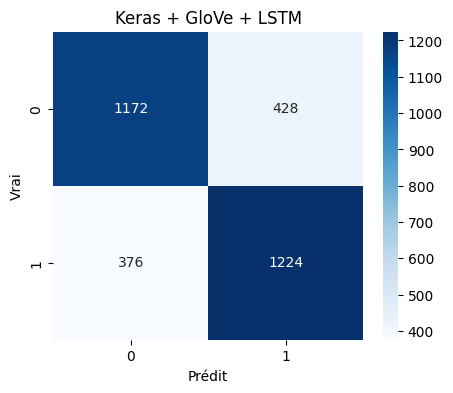

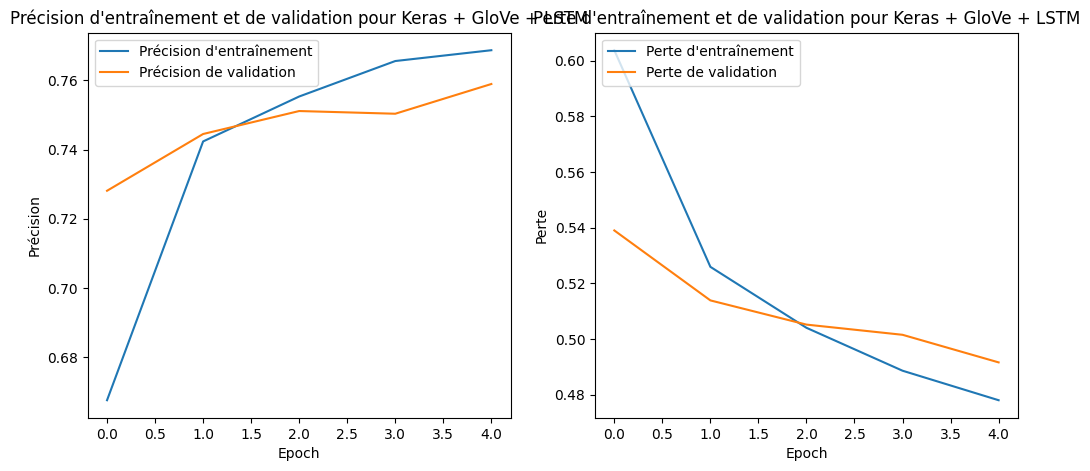

2025/08/14 14:42:16 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/14 14:42:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



-> Modèle: Keras + Word2Vec + LSTM
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


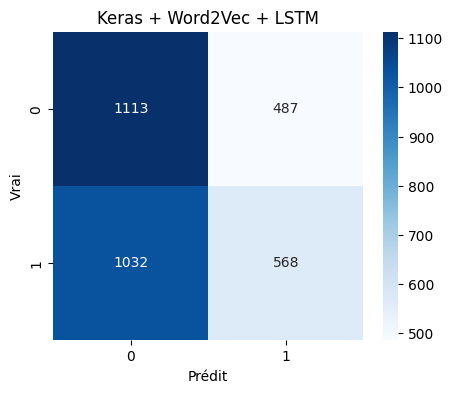

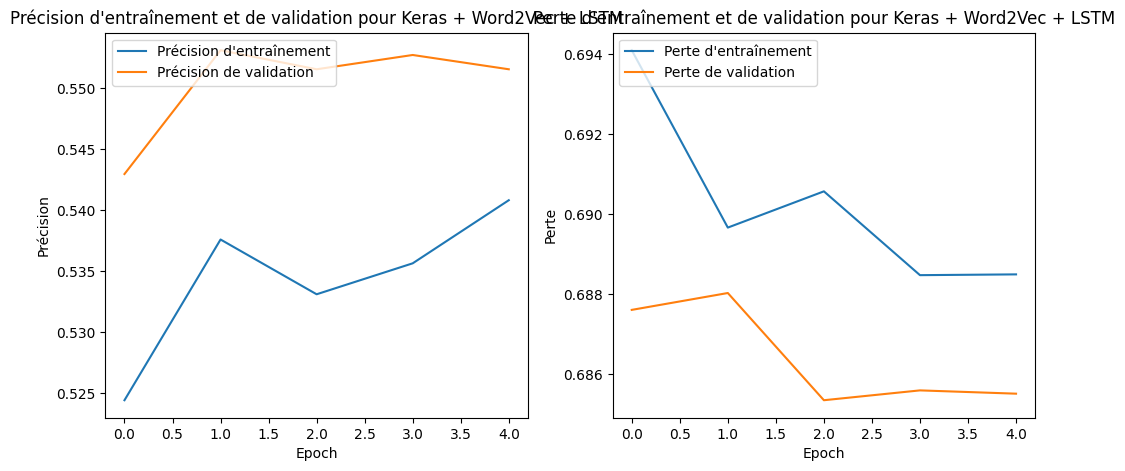

2025/08/14 14:42:29 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/14 14:42:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



-> Modèle: Keras + FastText + LSTM
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


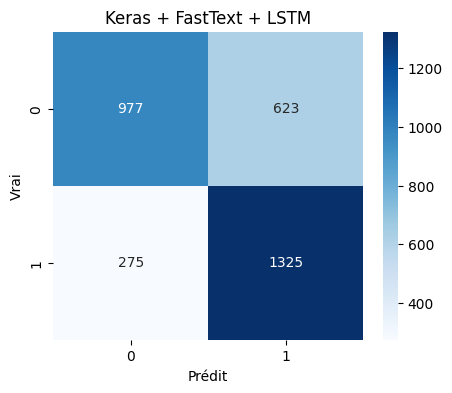

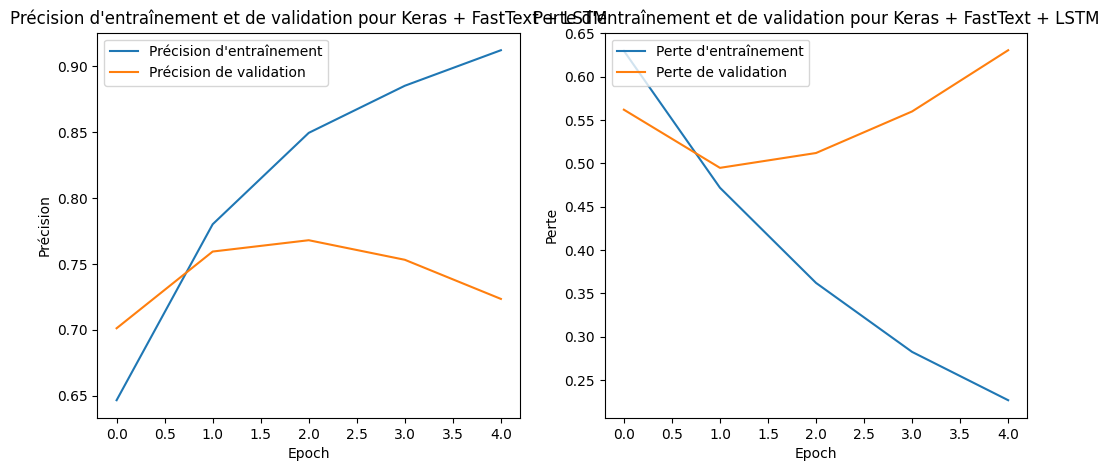

2025/08/14 14:42:43 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/14 14:42:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



-> Modèle: Keras + GRU
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


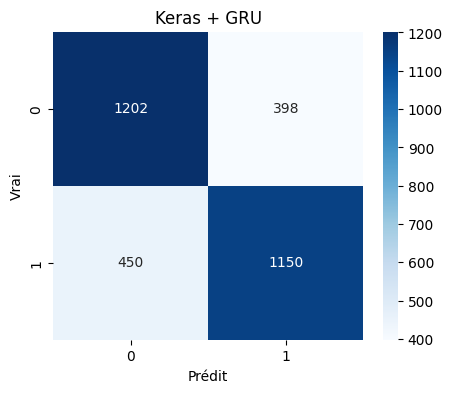

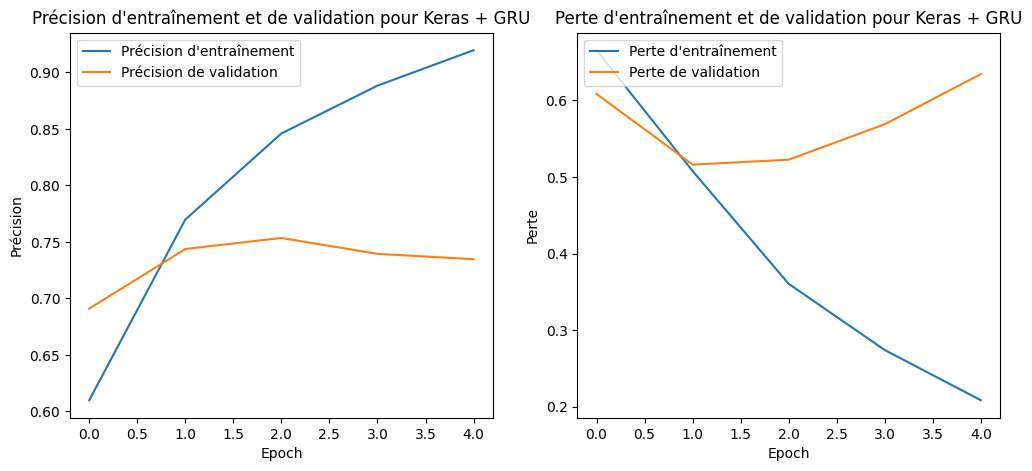

2025/08/14 14:42:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/14 14:43:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



-> Modèle: Keras + GloVe + GRU
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


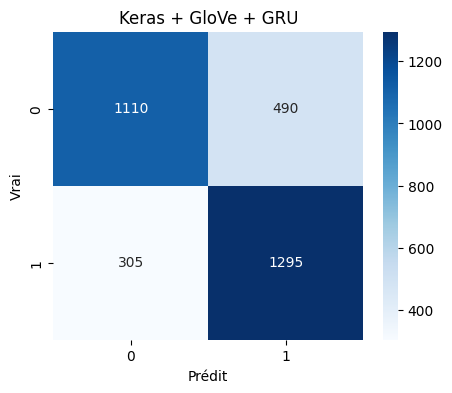

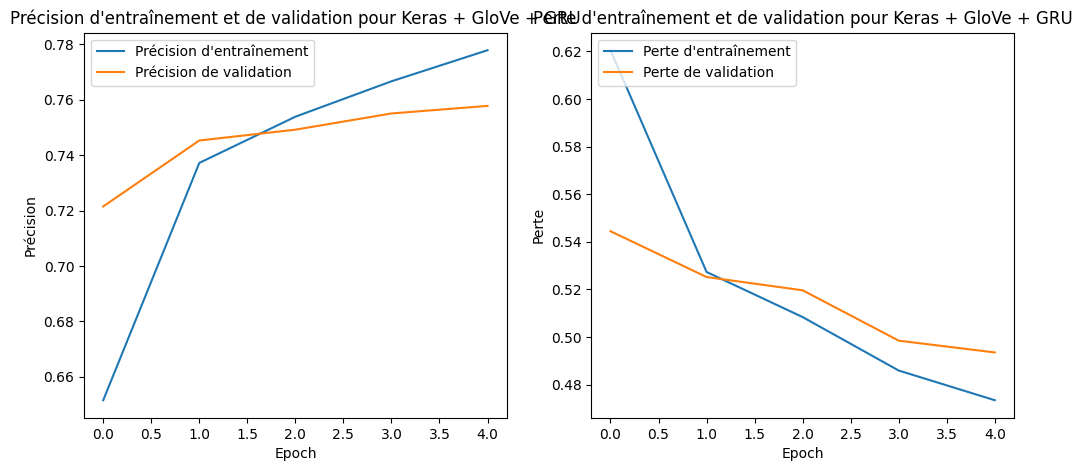

2025/08/14 14:43:09 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/14 14:43:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



-> Modèle: Keras + Word2Vec + GRU
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


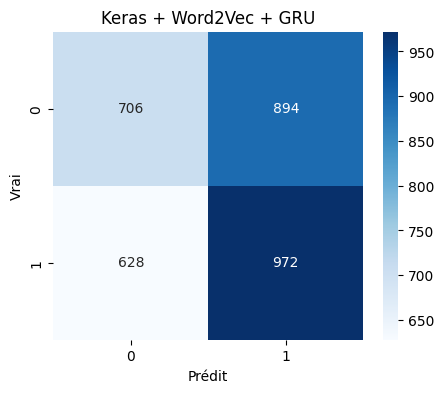

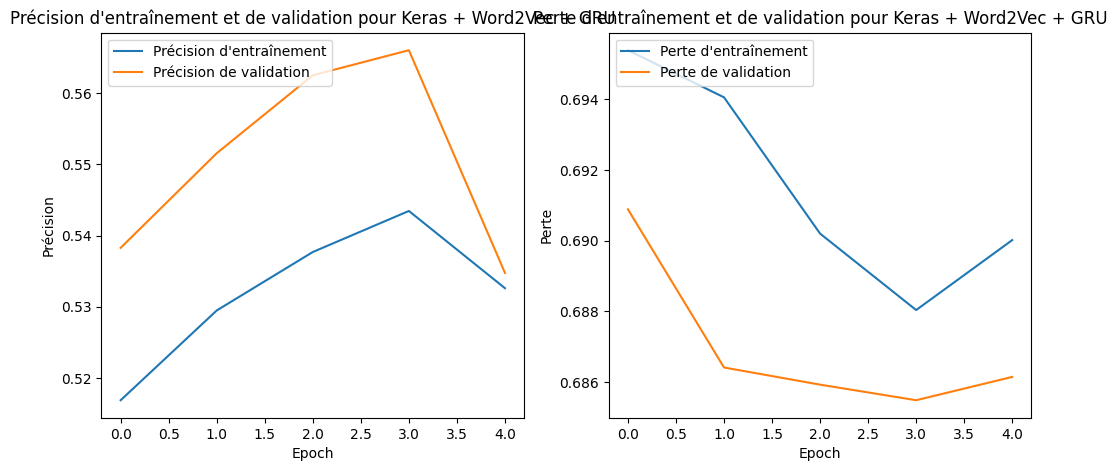

2025/08/14 14:43:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/14 14:43:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



-> Modèle: Keras + FastText + GRU
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


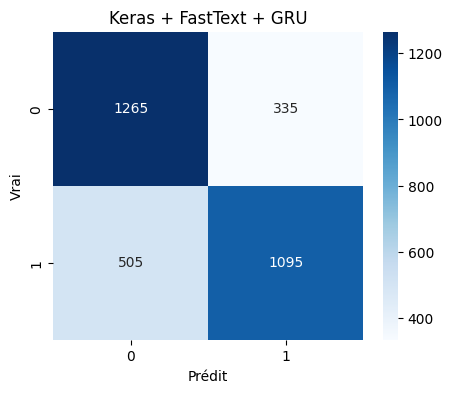

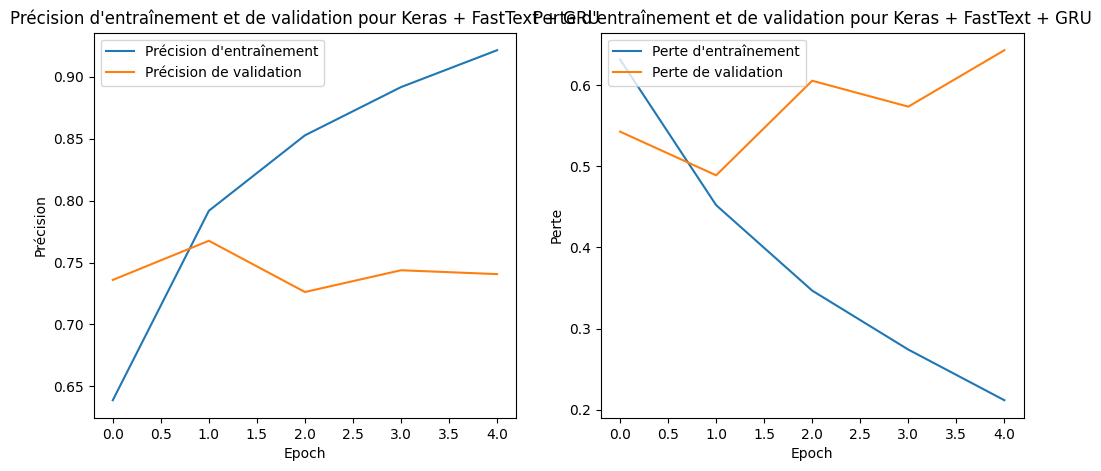

2025/08/14 14:43:36 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/14 14:43:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



-> Modèle: Keras + FastText + GRU Bidirectionnel
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


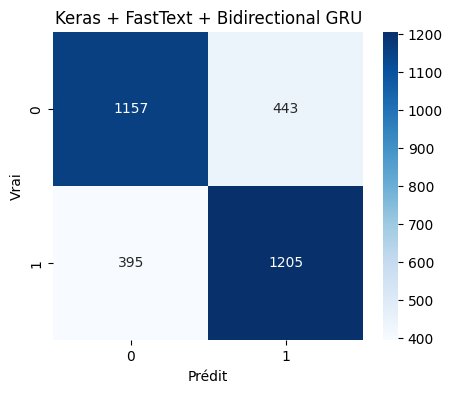

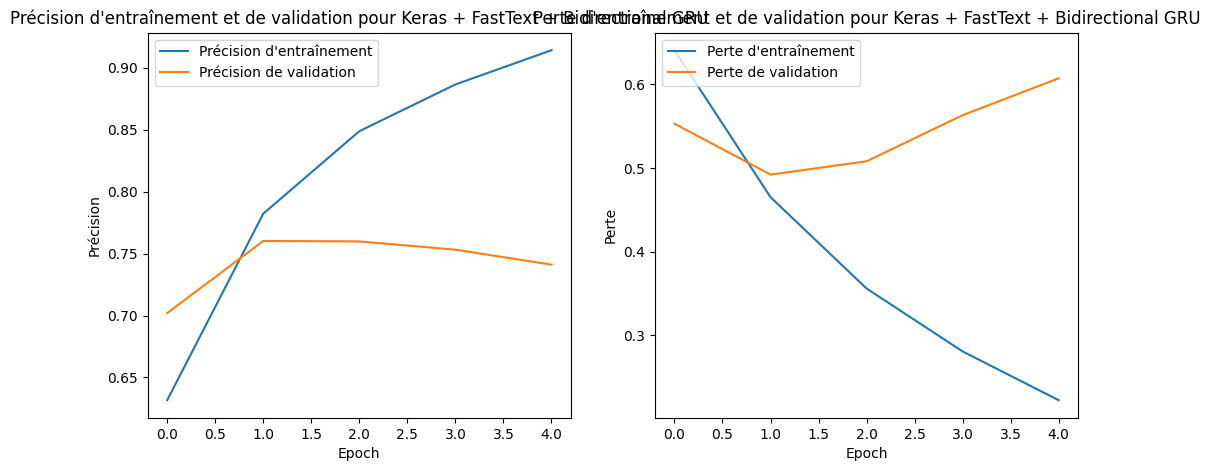

2025/08/14 14:43:52 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/14 14:44:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Tableau récapitulatif des résultats:
                               Model  Specificity  Precision    Recall  \
0                           LR+TFIDF     0.751875   0.755542  0.766875   
1                        Keras+GloVe     0.790000   0.778656  0.738750   
2         Keras+Word2Vec (sans LSTM)     0.755000   0.565891  0.319375   
3                     Keras+FastText     0.678750   0.717582  0.816250   
4                   Keras+GloVe+LSTM     0.732500   0.740920  0.765000   
5                Keras+Word2Vec+LSTM     0.695625   0.538389  0.355000   
6                Keras+FastText+LSTM     0.610625   0.680185  0.828125   
7                          Keras+GRU     0.751250   0.742894  0.718750   
8                    Keras+GloVe+GRU     0.693750   0.725490  0.809375   
9                 Keras+Word2Vec+GRU     0.441250   0.520900  0.607500   
10                Keras+FastText+GRU     0.790625   0.765734  0.684375   
11  Keras+FastText+Bidirectional_GRU     0.723125   0.731189  0.753125   


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Exemple 'non-badbuzz' -> Prédiction: Non-Badbuzz
Texte: '@jarvie that's why you get the big bucks '
Mots influents:
- that: 0.3392
- why: -0.3115
- bucks: 0.2496
- big: 0.1197
- you: 0.1034
- get: 0.0771
- jarvie: 0.0325
- the: -0.0254
- s: -0.0208


In [ ]:
# Ce script compare plusieurs modèles de classification de texte
# pour un problème de "badbuzz", en utilisant MLflow pour le suivi
# et LIME et SHAP pour l'explicabilité. Le meilleur modèle est choisi en se basant
# sur la Specificity, puis sur l'Accuracy.

# --- Importation des bibliothèques nécessaires ---
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
import mlflow
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Bidirectional
import fasttext
from lime.lime_text import LimeTextExplainer
import gensim
import matplotlib.pyplot as plt
import gensim.downloader as api
import fasttext.util
import gensim.models
from collections import defaultdict
import pickle
import os
import tempfile
import sys
from wordcloud import WordCloud
from PIL import Image
import shap
from IPython.display import display, HTML

# Activation de la compatibilité SHAP pour les notebooks
shap.initjs()

# --- Définition des fonctions utilitaires ---

def plot_wordclouds(df):
    """
    Génère et affiche des nuages de mots pour chaque classe (badbuzz et non-badbuzz).
    """
    print("\n--- Génération des nuages de mots ---")
    badbuzz_text_data = df[df['target'] == 0]['text']
    goodbuzz_text_data = df[df['target'] == 1]['text']

    badbuzz_text = " ".join(badbuzz_text_data)
    goodbuzz_text = " ".join(goodbuzz_text_data)

    if not badbuzz_text or not goodbuzz_text:
        print("Avertissement: Les données textuelles pour une ou plusieurs classes sont vides. Le nuage de mots ne sera pas généré.")
        return

    wordcloud_badbuzz = WordCloud(width=800, height=400, background_color='white').generate(badbuzz_text)
    wordcloud_goodbuzz = WordCloud(width=800, height=400, background_color='white').generate(goodbuzz_text)

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_badbuzz, interpolation='bilinear')
    plt.title("Nuage de mots pour les 'badbuzz'")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_goodbuzz, interpolation='bilinear')
    plt.title("Nuage de mots pour les 'non-badbuzz'")
    plt.axis("off")

    plt.show()

def analyze_best_model_with_shap(model_info, X_test, y_test):
    """
    Utilise la librairie SHAP pour analyser le meilleur modèle,
    fournissant des explications globales et locales.

    Arguments:
        model_info (dict): Informations sur le meilleur modèle.
        X_test (pd.Series): Données de test (texte brut).
        y_test (pd.Series): Étiquettes de test.
    """
    print(f"\n--- Analyse du meilleur modèle: {model_info['Model']} avec SHAP ---")

    # --- Préparation de l'explainer en fonction du type de modèle ---
    if 'LR' in model_info['Model']:
        model = model_info['model_obj']
        vectorizer = model_info['vectorizer_obj']
        pipeline = Pipeline([('tfidf', vectorizer), ('clf', model)])

        # Fonction de prédiction pour LR (pipeline)
        def lr_predict_proba_fn(texts):
            return pipeline.predict_proba(texts)

        # Données pour l'explainer
        background = X_test.iloc[0:100]
        print("Initialisation de SHAP Explainer pour la Régression Logistique...")
        explainer = shap.Explainer(lr_predict_proba_fn, background)

    else: # Modèles Keras
        model = model_info['model_obj']
        tokenizer = model_info.get('tokenizer_obj')
        max_len = model.input_shape[1]

        # Fonction de prédiction pour les modèles Keras, renvoyant les probabilités des deux classes
        def keras_predict_proba_fn(texts):
            sequences = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=max_len)
            predictions = model.predict(sequences)
            return np.hstack([1 - predictions, predictions])

        # Le PermutationExplainer est le plus adapté pour les modèles Keras
        background = X_test.sample(100, random_state=42)
        print("Initialisation de SHAP PermutationExplainer pour le modèle Keras...")
        explainer = shap.PermutationExplainer(keras_predict_proba_fn, background)

    # --- Explication Locale (premiers 10 échantillons) ---
    print("\nExplication Locale avec SHAP (premiers 10 échantillons):")
    try:
        shap_values = explainer(X_test.iloc[0:10])

        for i in range(10):
            print(f"\nExplication pour l'échantillon #{i} (Texte : \"{X_test.iloc[i]}\")")
            display(shap.force_plot(
                shap_values[i],
                features=X_test.iloc[i]
            ))
    except Exception as e:
        print(f"Erreur lors de la génération des explications locales SHAP : {e}")

    # --- Explication Globale ---
    print("\n" + "="*50)
    print("Explication Globale avec SHAP (Mots les plus influents):")
    try:
        sample_size = 200
        print(f"Calcul des valeurs SHAP pour l'explication globale sur {sample_size} échantillons...")

        # Calculer les valeurs SHAP pour l'échantillon global
        X_sample_text = X_test.sample(sample_size, random_state=42)
        shap_values_global = explainer(X_sample_text)

        # --- CORRECTION APPLIQUÉE ICI ---
        # Vérifier la dimension des valeurs SHAP pour éviter les erreurs
        if shap_values_global.values.ndim == 3:
            # Le cas attendu (n_samples, n_features, n_classes)
            # Plot pour la classe 0 (Badbuzz)
            print("\nImportance globale des mots pour la classe 0 (Badbuzz):")
            shap.summary_plot(shap_values_global[:, :, 0], max_display=30, show=False, class_names=['Badbuzz', 'Non-Badbuzz'])
            plt.title("Importance globale des mots pour la classe 0 (Badbuzz)")
            plt.show()

            # Plot pour la classe 1 (Non-Badbuzz)
            print("\nImportance globale des mots pour la classe 1 (Non-Badbuzz):")
            shap.summary_plot(shap_values_global[:, :, 1], max_display=30, show=False, class_names=['Badbuzz', 'Non-Badbuzz'])
            plt.title("Importance globale des mots pour la classe 1 (Non-Badbuzz)")
            plt.show()
        elif shap_values_global.values.ndim == 2:
            # Cas où SHAP renvoie un seul jeu de valeurs (n_samples, n_features)
            print("\nImportance globale des mots pour la classe 1 (Non-Badbuzz) :")
            print("Note : Le modèle étant binaire avec une sortie unique, les valeurs SHAP sont en 2D. Seul le graphique pour la classe 1 (Non-Badbuzz) est affiché.")
            shap.summary_plot(shap_values_global, max_display=30, show=False, class_names=['Badbuzz', 'Non-Badbuzz'])
            plt.title("Importance globale des mots pour la classe 1 (Non-Badbuzz)")
            plt.show()
        else:
            print("Erreur: Les valeurs SHAP ont une dimension inattendue.")

    except Exception as e:
        print(f"Erreur lors de la génération des explications globales SHAP : {e}")

def analyze_best_model_with_lime(model_info, X_test, y_test):
    """
    Utilise la librairie LIME pour analyser le meilleur modèle,
    fournissant des explications globales et locales.

    Arguments:
        model_info (dict): Informations sur le meilleur modèle.
        X_test (pd.Series): Données de test (texte brut).
        y_test (pd.Series): Étiquettes de test.
    """
    print(f"\n--- Analyse du meilleur modèle: {model_info['Model']} avec LIME ---")

    # Initialisation de l'explainer LIME
    explainer = LimeTextExplainer(class_names=['Badbuzz', 'Non-Badbuzz'])

    # Création de la fonction de prédiction unifiée pour LIME
    if 'LR' in model_info['Model']:
        model = model_info['model_obj']
        vectorizer = model_info['vectorizer_obj']
        def predict_proba_fn(texts):
            return model.predict_proba(vectorizer.transform(texts))
    else: # Modèles Keras
        model = model_info['model_obj']
        tokenizer = model_info.get('tokenizer_obj')
        max_len = model.input_shape[1]
        def predict_proba_fn(texts):
            sequences = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=max_len)
            predictions = model.predict(sequences)
            return np.hstack([1 - predictions, predictions])

    # --- Explication Globale (Agrégée) ---
    print("\nExplication Globale: Contribution moyenne des mots pour les deux classes.")
    sample_indices = y_test.sample(n=100, random_state=42).index
    feature_contributions = defaultdict(list)
    for i in sample_indices:
        text = X_test.loc[i]
        exp = explainer.explain_instance(text, predict_proba_fn, num_features=10)
        for feature, weight in exp.as_list():
            if predict_proba_fn([text])[0][1] > 0.5: # Si la prédiction est 'non-badbuzz'
                feature_contributions[feature].append(weight)
            else: # Si la prédiction est 'badbuzz'
                feature_contributions[feature].append(-weight)

    # Calcul de la contribution moyenne et affichage des mots les plus influents
    avg_contributions = {word: np.mean(weights) for word, weights in feature_contributions.items()}
    sorted_contributions = sorted(avg_contributions.items(), key=lambda item: item[1], reverse=True)

    print("\nMots les plus influents pour 'Non-Badbuzz' (contributions positives):")
    for word, weight in sorted_contributions[:10]:
        print(f"- {word}: {weight:.4f}")

    print("\nMots les plus influents pour 'Badbuzz' (contributions négatives):")
    for word, weight in sorted_contributions[-10:]:
        print(f"- {word}: {weight:.4f}")

    # --- Explication Locale ---
    print("\n" + "="*50)
    print("Explication Locale: Analyse d'un exemple 'badbuzz' et d'un 'non-badbuzz'.")
    badbuzz_sample_text = X_test[y_test == 0].sample(n=1, random_state=42).iloc[0]
    goodbuzz_sample_text = X_test[y_test == 1].sample(n=1, random_state=42).iloc[0]

    # Explication pour l'exemple 'badbuzz'
    exp_badbuzz = explainer.explain_instance(badbuzz_sample_text, predict_proba_fn, num_features=10)
    print(f"\nExemple 'badbuzz' -> Prédiction: {'Badbuzz' if predict_proba_fn([badbuzz_sample_text])[0][1] < 0.5 else 'Non-Badbuzz'}")
    print(f"Texte: '{badbuzz_sample_text}'")
    print("Mots influents:")
    for feature, weight in exp_badbuzz.as_list():
        print(f"- {feature}: {weight:.4f}")
    # Affichage du graphique de l'explication LIME
    display(HTML(exp_badbuzz.as_html()))

    # Explication pour l'exemple 'non-badbuzz'
    exp_goodbuzz = explainer.explain_instance(goodbuzz_sample_text, predict_proba_fn, num_features=10)
    print(f"\nExemple 'non-badbuzz' -> Prédiction: {'Badbuzz' if predict_proba_fn([goodbuzz_sample_text])[0][1] < 0.5 else 'Non-Badbuzz'}")
    print(f"Texte: '{goodbuzz_sample_text}'")
    print("Mots influents:")
    for feature, weight in exp_goodbuzz.as_list():
        print(f"- {feature}: {weight:.4f}")
    # Affichage du graphique de l'explication LIME
    display(HTML(exp_goodbuzz.as_html()))

def build_embedding_matrix(tokenizer, embedding_model, embedding_dim, vocab_size):
    """
    Construit une matrice d'embedding pour les modèles Keras en utilisant un modèle GloVe ou Word2Vec.
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < vocab_size:
            if word in embedding_model:
                embedding_matrix[i] = embedding_model[word]
    return embedding_matrix

def build_fasttext_embedding_matrix(tokenizer, ft_model, embedding_dim, vocab_size):
    """
    Construit une matrice d'embedding pour les modèles Keras en utilisant un modèle FastText.
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < vocab_size:
            embedding_matrix[i] = ft_model.get_word_vector(word)
    return embedding_matrix

def plot_conf_matrix(cm, title):
    """
    Trace une matrice de confusion avec Seaborn.
    """
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.show()

def plot_keras_history(history, model_name):
    """
    Trace la précision et la perte (loss) de l'entraînement et de la validation
    pour un modèle Keras.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Précision d\'entraînement')
    plt.plot(history.history['val_accuracy'], label='Précision de validation')
    plt.title(f'Précision d\'entraînement et de validation pour {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Précision')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perte d\'entraînement')
    plt.plot(history.history['val_loss'], label='Perte de validation')
    plt.title(f'Perte d\'entraînement et de validation pour {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Perte')
    plt.legend(loc='upper left')
    plt.show()

def compare_badbuzz_models(df):
    """
    Fonction principale pour entraîner et comparer différents modèles sur le DataFrame donné.
    """
    X = df['text']
    y = df['target'].replace({4:1}) # Badbuzz (0) reste 0, Non-badbuzz (4) devient 1

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

    results = []

    # --- Configuration et suivi MLflow ---
    mlflow_uri = "/content/drive/MyDrive/Colab Notebooks/mlruns"
    mlflow.set_tracking_uri(mlflow_uri)
    mlflow.set_experiment("BadBuzz_Comparison")

    # --- Hyperparamètres et préparation des données pour Keras ---
    vocab_size = 10000
    embedding_dim = 100
    max_len = 40
    epochs = 5
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)
    X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
    X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_len)
    X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

    # --- Entraînement des modèles ---
    print("\n--- Entraînement des modèles ---")

    # 1. Régression Logistique + TFIDF
    with mlflow.start_run(run_name="LR_TFIDF_Model"):
        print("-> Modèle: LR + TFIDF")
        start_time_train = time.time()
        tfidf = TfidfVectorizer(max_features=5000)
        X_train_tfidf = tfidf.fit_transform(X_train)
        X_test_tfidf = tfidf.transform(X_test)
        lr = LogisticRegression(solver='liblinear', random_state=42)
        lr.fit(X_train_tfidf, y_train)
        end_time_train = time.time()
        start_time_inference = time.time()
        y_pred = lr.predict(X_test_tfidf)
        y_pred_proba = lr.predict_proba(X_test_tfidf)[:, 1]
        end_time_inference = time.time()
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        training_time = end_time_train - start_time_train
        inference_time = end_time_inference - start_time_inference
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("specificity", specificity)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("inference_time_sec", inference_time)
        mlflow.log_metric("training_time_sec", training_time)
        plot_conf_matrix(cm, "LR + TFIDF")
        results.append({"Model":"LR+TFIDF", "Specificity":specificity, "Precision":precision, "Recall":recall, "F1-Score":f1, "AUC":auc_score, "Accuracy":accuracy, "model_obj":lr, "vectorizer_obj":tfidf})

    with mlflow.start_run(run_name="Tokenizer_and_Data_Prep"):
        save_path = "/content/drive/MyDrive/Colab Notebooks/saved_model/lstm"
        os.makedirs(save_path, exist_ok=True)
        tokenizer_path = os.path.join(save_path, 'tokenizer.pkl')
        with open(tokenizer_path, 'wb') as f:
            pickle.dump(tokenizer, f)
        mlflow.log_artifact(tokenizer_path, "tokenizer")
        print(f"Tokenizer enregistré à : {tokenizer_path}")
        mlflow.log_params({"vocab_size": vocab_size, "embedding_dim": embedding_dim, "max_len": max_len})

    # Préparation des embeddings pour les modèles Keras
    try:
        glove = api.load("glove-twitter-100")
        glove_matrix = build_embedding_matrix(tokenizer, glove, embedding_dim, vocab_size)
    except Exception as e:
        print(f"Erreur lors du chargement du modèle GloVe : {e}. Création d'une matrice d'embedding vide.")
        glove_matrix = np.zeros((vocab_size, embedding_dim))

    try:
        w2v = gensim.models.Word2Vec([t.split() for t in X_train], vector_size=embedding_dim, min_count=1, workers=4)
        w2v_matrix = build_embedding_matrix(tokenizer, w2v.wv, embedding_dim, vocab_size)
    except Exception as e:
        print(f"Erreur lors de la construction du modèle Word2Vec : {e}. Création d'une matrice d'embedding vide.")
        w2v_matrix = np.zeros((vocab_size, embedding_dim))

    print("\nChargement du modèle FastText en anglais (cc.en.300.bin)...")
    try:
        fasttext.util.download_model('en', if_exists='ignore')
        ft = fasttext.load_model('cc.en.300.bin')
        fasttext.util.reduce_model(ft, embedding_dim)
        ft_matrix = build_fasttext_embedding_matrix(tokenizer, ft, embedding_dim, vocab_size)
    except Exception as e:
        print(f"Erreur lors du chargement du modèle FastText en anglais: {e}")
        ft_matrix = np.zeros((vocab_size, embedding_dim)) # Matrice vide en cas d'échec

    # 2. Keras + GloVe (sans LSTM)
    with mlflow.start_run(run_name="Keras_GloVe_Model"):
        print("\n-> Modèle: Keras + GloVe (sans LSTM)")
        model_glove_no_lstm = Sequential([
            Embedding(vocab_size, embedding_dim, weights=[glove_matrix], input_length=max_len, trainable=False),
            Conv1D(128, 5, activation='relu'),
            GlobalMaxPooling1D(),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model_glove_no_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        start_time_train = time.time()
        history_glove_no_lstm = model_glove_no_lstm.fit(X_train_seq, y_train, epochs=epochs, validation_data=(X_val_seq, y_val), batch_size=128, verbose=0)
        end_time_train = time.time()
        start_time_inference = time.time()
        y_pred_proba = model_glove_no_lstm.predict(X_test_seq).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        end_time_inference = time.time()
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        training_time = end_time_train - start_time_train
        inference_time = end_time_inference - start_time_inference
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("specificity", specificity)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("inference_time_sec", inference_time)
        mlflow.log_metric("training_time_sec", training_time)
        plot_conf_matrix(cm, "Keras + GloVe")
        plot_keras_history(history_glove_no_lstm, "Keras + GloVe")
        results.append({"Model":"Keras+GloVe", "Specificity":specificity, "Precision":precision, "Recall":recall, "F1-Score":f1, "AUC":auc_score, "Accuracy":accuracy, "model_obj":model_glove_no_lstm, 'tokenizer_obj': tokenizer})
        mlflow.log_params({"model_name": "Keras_GloVe", "embedding_type": "GloVe"})
        mlflow.keras.log_model(model_glove_no_lstm, name="keras_glove_model")

    # 3. Keras + Word2Vec (sans LSTM)
    with mlflow.start_run(run_name="Keras_Word2Vec_No_LSTM_Model"):
        print("\n-> Modèle: Keras + Word2Vec (sans LSTM)")
        model_w2v_no_lstm = Sequential([
            Embedding(vocab_size, embedding_dim, weights=[w2v_matrix], input_length=max_len, trainable=False),
            Conv1D(128, 5, activation='relu'),
            GlobalMaxPooling1D(),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model_w2v_no_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        start_time_train = time.time()
        history_w2v_no_lstm = model_w2v_no_lstm.fit(X_train_seq, y_train, epochs=epochs, validation_data=(X_val_seq, y_val), batch_size=128, verbose=0)
        end_time_train = time.time()
        start_time_inference = time.time()
        y_pred_proba = model_w2v_no_lstm.predict(X_test_seq).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        end_time_inference = time.time()
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        training_time = end_time_train - start_time_train
        inference_time = end_time_inference - start_time_inference
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("specificity", specificity)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("inference_time_sec", inference_time)
        mlflow.log_metric("training_time_sec", training_time)
        plot_conf_matrix(cm, "Keras + Word2Vec (sans LSTM)")
        plot_keras_history(history_w2v_no_lstm, "Keras + Word2Vec (sans LSTM)")
        results.append({"Model":"Keras+Word2Vec (sans LSTM)", "Specificity":specificity, "Precision":precision, "Recall":recall, "F1-Score":f1, "AUC":auc_score, "Accuracy":accuracy, "model_obj":model_w2v_no_lstm, 'tokenizer_obj': tokenizer})
        mlflow.log_params({"model_name": "Keras_Word2Vec_No_LSTM", "embedding_type": "Word2Vec"})
        mlflow.keras.log_model(model_w2v_no_lstm, name="keras_word2vec_no_lstm_model")

    # 4. Keras + FastText (sans LSTM)
    with mlflow.start_run(run_name="Keras_FastText_Model"):
        print("\n-> Modèle: Keras + FastText (sans LSTM)")
        model_ft_no_lstm = Sequential([
            Embedding(vocab_size, embedding_dim, weights=[ft_matrix], input_length=max_len, trainable=True),
            Conv1D(128, 5, activation='relu'),
            GlobalMaxPooling1D(),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model_ft_no_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        start_time_train = time.time()
        history_ft_no_lstm = model_ft_no_lstm.fit(X_train_seq, y_train, epochs=epochs, validation_data=(X_val_seq, y_val), batch_size=128, verbose=0)
        end_time_train = time.time()
        start_time_inference = time.time()
        y_pred_proba = model_ft_no_lstm.predict(X_test_seq).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        end_time_inference = time.time()
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        training_time = end_time_train - start_time_train
        inference_time = end_time_inference - start_time_inference
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("specificity", specificity)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("inference_time_sec", inference_time)
        mlflow.log_metric("training_time_sec", training_time)
        plot_conf_matrix(cm, "Keras + FastText")
        plot_keras_history(history_ft_no_lstm, "Keras + FastText")
        results.append({"Model":"Keras+FastText", "Specificity":specificity, "Precision":precision, "Recall":recall, "F1-Score":f1, "AUC":auc_score, "Accuracy":accuracy, "model_obj":model_ft_no_lstm, 'tokenizer_obj': tokenizer})
        mlflow.log_params({"model_name": "Keras_FastText", "embedding_type": "FastText"})
        mlflow.keras.log_model(model_ft_no_lstm, name="keras_fasttext_model")

    # 5. Keras + GloVe + LSTM
    with mlflow.start_run(run_name="Keras_GloVe_LSTM_Model"):
        print("\n-> Modèle: Keras + GloVe + LSTM")
        model_glove_lstm = Sequential([
            Embedding(vocab_size, embedding_dim, weights=[glove_matrix], input_length=max_len, trainable=False),
            LSTM(64),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model_glove_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        start_time_train = time.time()
        history_glove_lstm = model_glove_lstm.fit(X_train_seq, y_train, epochs=epochs, validation_data=(X_val_seq, y_val), batch_size=128, verbose=0)
        end_time_train = time.time()
        start_time_inference = time.time()
        y_pred_proba = model_glove_lstm.predict(X_test_seq).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        end_time_inference = time.time()
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        training_time = end_time_train - start_time_train
        inference_time = end_time_inference - start_time_inference
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("specificity", specificity)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("inference_time_sec", inference_time)
        mlflow.log_metric("training_time_sec", training_time)
        plot_conf_matrix(cm, "Keras + GloVe + LSTM")
        plot_keras_history(history_glove_lstm, "Keras + GloVe + LSTM")
        results.append({"Model":"Keras+GloVe+LSTM", "Specificity":specificity, "Precision":precision, "Recall":recall, "F1-Score":f1, "AUC":auc_score, "Accuracy":accuracy, "model_obj":model_glove_lstm, 'tokenizer_obj': tokenizer})
        mlflow.log_params({"model_name": "Keras_GloVe_LSTM", "embedding_type": "GloVe"})
        mlflow.keras.log_model(model_glove_lstm, name="keras_glove_lstm_model")

    # 6. Keras + Word2Vec + LSTM
    with mlflow.start_run(run_name="Keras_Word2Vec_LSTM_Model"):
        print("\n-> Modèle: Keras + Word2Vec + LSTM")
        model_w2v_lstm = Sequential([
            Embedding(vocab_size, embedding_dim, weights=[w2v_matrix], input_length=max_len, trainable=False),
            LSTM(64),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model_w2v_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        start_time_train = time.time()
        history_w2v_lstm = model_w2v_lstm.fit(X_train_seq, y_train, epochs=epochs, validation_data=(X_val_seq, y_val), batch_size=128, verbose=0)
        end_time_train = time.time()
        start_time_inference = time.time()
        y_pred_proba = model_w2v_lstm.predict(X_test_seq).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        end_time_inference = time.time()
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        training_time = end_time_train - start_time_train
        inference_time = end_time_inference - start_time_inference
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("specificity", specificity)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("inference_time_sec", inference_time)
        mlflow.log_metric("training_time_sec", training_time)
        plot_conf_matrix(cm, "Keras + Word2Vec + LSTM")
        plot_keras_history(history_w2v_lstm, "Keras + Word2Vec + LSTM")
        results.append({"Model":"Keras+Word2Vec+LSTM", "Specificity":specificity, "Precision":precision, "Recall":recall, "F1-Score":f1, "AUC":auc_score, "Accuracy":accuracy, "model_obj":model_w2v_lstm, 'tokenizer_obj': tokenizer})
        mlflow.log_params({"model_name": "Keras_W2V_LSTM", "embedding_type": "Word2Vec"})
        mlflow.keras.log_model(model_w2v_lstm, name="keras_w2v_lstm_model")

    # 7. Keras + FastText + LSTM
    with mlflow.start_run(run_name="Keras_FastText_LSTM_Model"):
        print("\n-> Modèle: Keras + FastText + LSTM")
        model_ft_lstm = Sequential([
            Embedding(vocab_size, embedding_dim, weights=[ft_matrix], input_length=max_len, trainable=True),
            LSTM(64),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model_ft_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        start_time_train = time.time()
        history_ft_lstm = model_ft_lstm.fit(X_train_seq, y_train, epochs=epochs, validation_data=(X_val_seq, y_val), batch_size=128, verbose=0)
        end_time_train = time.time()
        start_time_inference = time.time()
        y_pred_proba = model_ft_lstm.predict(X_test_seq).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        end_time_inference = time.time()
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        training_time = end_time_train - start_time_train
        inference_time = end_time_inference - start_time_inference
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("specificity", specificity)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("inference_time_sec", inference_time)
        mlflow.log_metric("training_time_sec", training_time)
        plot_conf_matrix(cm, "Keras + FastText + LSTM")
        plot_keras_history(history_ft_lstm, "Keras + FastText + LSTM")
        results.append({"Model":"Keras+FastText+LSTM", "Specificity":specificity, "Precision":precision, "Recall":recall, "F1-Score":f1, "AUC":auc_score, "Accuracy":accuracy, "model_obj":model_ft_lstm, 'tokenizer_obj': tokenizer})
        mlflow.log_params({"model_name": "Keras_FT_LSTM", "embedding_type": "FastText"})
        mlflow.keras.log_model(model_ft_lstm, name="keras_fasttext_lstm_model")

    # 8. Keras + GRU
    with mlflow.start_run(run_name="Keras_GRU_Model"):
        print("\n-> Modèle: Keras + GRU")
        model_gru = Sequential([
            Embedding(vocab_size, embedding_dim, input_length=max_len),
            GRU(64),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        start_time_train = time.time()
        history_gru = model_gru.fit(X_train_seq, y_train, epochs=epochs, validation_data=(X_val_seq, y_val), batch_size=128, verbose=0)
        end_time_train = time.time()
        start_time_inference = time.time()
        y_pred_proba = model_gru.predict(X_test_seq).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        end_time_inference = time.time()
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        training_time = end_time_train - start_time_train
        inference_time = end_time_inference - start_time_inference
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("specificity", specificity)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("inference_time_sec", inference_time)
        mlflow.log_metric("training_time_sec", training_time)
        plot_conf_matrix(cm, "Keras + GRU")
        plot_keras_history(history_gru, "Keras + GRU")
        results.append({"Model":"Keras+GRU", "Specificity":specificity, "Precision":precision, "Recall":recall, "F1-Score":f1, "AUC":auc_score, "Accuracy":accuracy, "model_obj":model_gru, 'tokenizer_obj': tokenizer})
        mlflow.log_params({"model_name": "Keras_GRU", "embedding_type": "Keras"})
        mlflow.keras.log_model(model_gru, name="keras_gru_model")

    # 9. Keras + GloVe + GRU
    with mlflow.start_run(run_name="Keras_GloVe_GRU_Model"):
        print("\n-> Modèle: Keras + GloVe + GRU")
        model_glove_gru = Sequential([
            Embedding(vocab_size, embedding_dim, weights=[glove_matrix], input_length=max_len, trainable=False),
            GRU(64),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model_glove_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        start_time_train = time.time()
        history_glove_gru = model_glove_gru.fit(X_train_seq, y_train, epochs=epochs, validation_data=(X_val_seq, y_val), batch_size=128, verbose=0)
        end_time_train = time.time()
        start_time_inference = time.time()
        y_pred_proba = model_glove_gru.predict(X_test_seq).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        end_time_inference = time.time()
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        training_time = end_time_train - start_time_train
        inference_time = end_time_inference - start_time_inference
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("specificity", specificity)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("inference_time_sec", inference_time)
        mlflow.log_metric("training_time_sec", training_time)
        plot_conf_matrix(cm, "Keras + GloVe + GRU")
        plot_keras_history(history_glove_gru, "Keras + GloVe + GRU")
        results.append({"Model":"Keras+GloVe+GRU", "Specificity":specificity, "Precision":precision, "Recall":recall, "F1-Score":f1, "AUC":auc_score, "Accuracy":accuracy, "model_obj":model_glove_gru, 'tokenizer_obj': tokenizer})
        mlflow.log_params({"model_name": "Keras_GloVe_GRU", "embedding_type": "GloVe"})
        mlflow.keras.log_model(model_glove_gru, name="keras_glove_gru_model")

    # 10. Keras + Word2Vec + GRU
    with mlflow.start_run(run_name="Keras_Word2Vec_GRU_Model"):
        print("\n-> Modèle: Keras + Word2Vec + GRU")
        model_w2v_gru = Sequential([
            Embedding(vocab_size, embedding_dim, weights=[w2v_matrix], input_length=max_len, trainable=False),
            GRU(64),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model_w2v_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        start_time_train = time.time()
        history_w2v_gru = model_w2v_gru.fit(X_train_seq, y_train, epochs=epochs, validation_data=(X_val_seq, y_val), batch_size=128, verbose=0)
        end_time_train = time.time()
        start_time_inference = time.time()
        y_pred_proba = model_w2v_gru.predict(X_test_seq).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        end_time_inference = time.time()
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        training_time = end_time_train - start_time_train
        inference_time = end_time_inference - start_time_inference
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("specificity", specificity)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("inference_time_sec", inference_time)
        mlflow.log_metric("training_time_sec", training_time)
        plot_conf_matrix(cm, "Keras + Word2Vec + GRU")
        plot_keras_history(history_w2v_gru, "Keras + Word2Vec + GRU")
        results.append({"Model":"Keras+Word2Vec+GRU", "Specificity":specificity, "Precision":precision, "Recall":recall, "F1-Score":f1, "AUC":auc_score, "Accuracy":accuracy, "model_obj":model_w2v_gru, 'tokenizer_obj': tokenizer})
        mlflow.log_params({"model_name": "Keras_W2V_GRU", "embedding_type": "Word2Vec"})
        mlflow.keras.log_model(model_w2v_gru, name="keras_w2v_gru_model")

    # 11. Keras + FastText + GRU
    with mlflow.start_run(run_name="Keras_FastText_GRU_Model"):
        print("\n-> Modèle: Keras + FastText + GRU")
        model_ft_gru = Sequential([
            Embedding(vocab_size, embedding_dim, weights=[ft_matrix], input_length=max_len, trainable=True),
            GRU(64),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model_ft_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        start_time_train = time.time()
        history_ft_gru = model_ft_gru.fit(X_train_seq, y_train, epochs=epochs, validation_data=(X_val_seq, y_val), batch_size=128, verbose=0)
        end_time_train = time.time()
        start_time_inference = time.time()
        y_pred_proba = model_ft_gru.predict(X_test_seq).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        end_time_inference = time.time()
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        training_time = end_time_train - start_time_train
        inference_time = end_time_inference - start_time_inference
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("specificity", specificity)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("inference_time_sec", inference_time)
        mlflow.log_metric("training_time_sec", training_time)
        plot_conf_matrix(cm, "Keras + FastText + GRU")
        plot_keras_history(history_ft_gru, "Keras + FastText + GRU")
        results.append({"Model":"Keras+FastText+GRU", "Specificity":specificity, "Precision":precision, "Recall":recall, "F1-Score":f1, "AUC":auc_score, "Accuracy":accuracy, "model_obj":model_ft_gru, 'tokenizer_obj': tokenizer})
        mlflow.log_params({"model_name": "Keras_FT_GRU", "embedding_type": "FastText"})
        mlflow.keras.log_model(model_ft_gru, name="keras_fasttext_gru_model")

    # 12. Nouveau modèle: Keras + Bidirectional GRU + FastText
    with mlflow.start_run(run_name="Keras_FastText_Bidirectional_GRU_Model"):
        print("\n-> Modèle: Keras + FastText + GRU Bidirectionnel")
        model_ft_bi_gru = Sequential([
            Embedding(vocab_size, embedding_dim, weights=[ft_matrix], input_length=max_len, trainable=True),
            Bidirectional(GRU(64)),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        model_ft_bi_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        start_time_train = time.time()
        history_ft_bi_gru = model_ft_bi_gru.fit(X_train_seq, y_train, epochs=epochs, validation_data=(X_val_seq, y_val), batch_size=128, verbose=0)
        end_time_train = time.time()
        start_time_inference = time.time()
        y_pred_proba = model_ft_bi_gru.predict(X_test_seq).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        end_time_inference = time.time()
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        training_time = end_time_train - start_time_train
        inference_time = end_time_inference - start_time_inference
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("specificity", specificity)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("inference_time_sec", inference_time)
        mlflow.log_metric("training_time_sec", training_time)
        plot_conf_matrix(cm, "Keras + FastText + Bidirectional GRU")
        plot_keras_history(history_ft_bi_gru, "Keras + FastText + Bidirectional GRU")
        results.append({"Model":"Keras+FastText+Bidirectional_GRU", "Specificity":specificity, "Precision":precision, "Recall":recall, "F1-Score":f1, "AUC":auc_score, "Accuracy":accuracy, "model_obj":model_ft_bi_gru, 'tokenizer_obj': tokenizer})
        mlflow.log_params({"model_name": "Keras_FT_BI_GRU", "embedding_type": "FastText"})
        mlflow.keras.log_model(model_ft_bi_gru, name="keras_fasttext_bi_gru_model")


    # Tableau récapitulatif des résultats
    results_df = pd.DataFrame(results)
    print("\nTableau récapitulatif des résultats:")
    print(results_df)

    # Détermination du meilleur modèle basé sur la spécificité, puis l'accuracy en cas d'égalité
    best_model_info = results_df.sort_values(by=['Specificity', 'Accuracy'], ascending=[False, False]).iloc[0]
    print("\nMeilleur modèle :", best_model_info["Model"])
    print(f"Spécificité: {best_model_info['Specificity']:.4f}, Précision: {best_model_info['Accuracy']:.4f}")

    # --- Appel de la fonction d'explication pour le meilleur modèle ---
    analyze_best_model_with_shap(best_model_info, X_test, y_test)
    analyze_best_model_with_lime(best_model_info, X_test, y_test)

# --- ANALYSE DE L'ÉCHANTILLON ---
print("\n--- Analyse de l'échantillon de 16 000 observations ---")


print("\nStatistiques sur le nombre de mots par tweet :")
print(df_sampled['word_count'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df_sampled['word_count'], bins=20, kde=True, color='skyblue')
plt.title("Distribution du nombre de mots par tweet")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.show()

plot_wordclouds(df_sampled)

if __name__ == '__main__':
    compare_badbuzz_models(df_sampled)


optimisation

In [ ]:
mlflow.end_run()

In [ ]:
# -*- coding: utf-8 -*-

# Importation des bibliothèques nécessaires
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import urllib.request
import time
import mlflow
import mlflow.keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import shap
from lime.lime_text import LimeTextExplainer

# Empêcher Matplotlib d'ouvrir des fenêtres (important pour les environnements sans affichage)
plt.switch_backend('Agg')

# --- Paramètres globaux ---
SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks'
MLFLOW_TRACKING_URI = os.path.join(SAVE_PATH, 'mlruns')
FASTTEXT_MODEL_URL = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz'
FASTTEXT_MODEL_PATH = os.path.join(SAVE_PATH, 'cc.en.300.vec')
EMBEDDING_DIM = 300
MAX_LEN = 50
EPOCHS = 20
BATCH_SIZE = 32
DB_NAME = "review_sentiment_analysis" # Nom de la base de données ou du jeu de données
# Nombre d'échantillons à expliquer pour LIME et SHAP
NUM_EXPLANATIONS = 3

# S'assurer que les répertoires existent
os.makedirs(SAVE_PATH, exist_ok=True)
os.makedirs(MLFLOW_TRACKING_URI, exist_ok=True)

# --- 1. Installation des bibliothèques (si nécessaire) ---
try:
    import fasttext
    import gensim
    import sklearn
    import mlflow
    import shap
    import lime
    print("Les bibliothèques fasttext, gensim, scikit-learn, mlflow, shap et lime sont déjà installées.")
except ImportError:
    print("Installation des bibliothèques fasttext, gensim, scikit-learn, mlflow, shap et lime...")
    !pip install fasttext gensim scikit-learn mlflow shap lime
    import fasttext
    from gensim.models import KeyedVectors
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    import shap
    from lime.lime_text import LimeTextExplainer


# --- 2. Téléchargement et chargement des vecteurs FastText avec Gensim ---
def load_fasttext_vectors():
    """Télécharge et charge les vecteurs FastText pré-entraînés en anglais en utilisant Gensim."""
    if not os.path.exists(FASTTEXT_MODEL_PATH):
        print(f"Téléchargement du modèle FastText anglais ({FASTTEXT_MODEL_URL})...")
        urllib.request.urlretrieve(FASTTEXT_MODEL_URL, f"{FASTTEXT_MODEL_PATH}.gz")
        print("Décompression du fichier...")
        import gzip
        with gzip.open(f"{FASTTEXT_MODEL_PATH}.gz", 'rb') as f_in:
            with open(FASTTEXT_MODEL_PATH, 'wb') as f_out:
                f_out.write(f_in.read())
        os.remove(f"{FASTTEXT_MODEL_PATH}.gz")
        print("Vecteurs FastText anglais téléchargés et décompressés.")
    else:
        print("Les vecteurs FastText anglais sont déjà présents, pas de téléchargement nécessaire.")

    print("Chargement des vecteurs FastText avec Gensim...")
    ft_vectors = KeyedVectors.load_word2vec_format(FASTTEXT_MODEL_PATH)
    return ft_vectors

# --- 3. Préparation des données d'entraînement (exemple fictif) ---
df.describe()
# --- 4. Construction et entraînement du modèle ---
def build_and_train_model(X_train, y_train, ft_vectors):
    """
    Construit un modèle Keras optimisé avec une couche d'embedding FastText
    et une couche GRU bidirectionnelle, puis entraîne le modèle avec des callbacks.
    """
    start_time = time.time()

    # Tokenisation des textes
    tokenizer = Tokenizer(oov_token="<unk>")
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1

    # Création de la matrice d'embedding
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in word_index.items():
        if word in ft_vectors:
            embedding_matrix[i] = ft_vectors[word]

    # Prétraitement des séquences
    sequences = tokenizer.texts_to_sequences(X_train)
    padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

    # Construction du modèle optimisé avec GRU bidirectionnelle
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_LEN,
            trainable=False
        ),
        Bidirectional(GRU(128, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(GRU(64)),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    # Définition des métriques et de l'optimiseur
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    print("\nRésumé du modèle optimisé avec GRU bidirectionnelle:")
    model.summary()

    # Définition des callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_auc',
            patience=3,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            filepath=os.path.join(SAVE_PATH, 'best_gensim_bidirectional_gru_en_model.keras'),
            monitor='val_auc',
            save_best_only=True,
            verbose=1
        )
    ]

    # Entraînement du modèle
    print("\nEntraînement du modèle optimisé sur les données ...")
    model.fit(
        padded_sequences,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )

    training_time = time.time() - start_time
    print("\nEntraînement terminé. Le meilleur modèle est sauvegardé.")

    return model, tokenizer, training_time

# --- 5. Fonction pour évaluer toutes les métriques et l'inférence ---
def evaluate_model_metrics(model, tokenizer, X_test, y_test):
    """
    Charge le meilleur modèle et le tokenizer sauvegardés, prédit sur le jeu de test,
    et calcule toutes les métriques d'évaluation.
    """
    start_time = time.time()

    # Prétraitement des données de test
    sequences_test = tokenizer.texts_to_sequences(X_test)
    padded_sequences_test = pad_sequences(sequences_test, maxlen=MAX_LEN, padding='post', truncating='post')

    # Faire des prédictions
    y_pred_proba = model.predict(padded_sequences_test, verbose=0)
    y_pred_classes = (y_pred_proba > 0.5).astype("int32")

    inference_time = time.time() - start_time

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, zero_division=0)
    recall = recall_score(y_test, y_pred_classes, zero_division=0)
    f1_score_val = f1_score(y_test, y_pred_classes, zero_division=0)
    auc_score = tf.keras.metrics.AUC()
    auc_score.update_state(y_test, y_pred_proba)
    auc_score = auc_score.result().numpy()

    # Calcul de la matrice de confusion pour la spécificité
    cm = confusion_matrix(y_test, y_pred_classes)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print("\n--- Évaluation du Modèle ---")
    print(f"Spécificité (Specificity): {specificity:.4f} (nouvelle métrique affichée en priorité)")
    print(f"Précision (Accuracy): {accuracy:.4f}")
    print(f"Précision (Precision): {precision:.4f}")
    print(f"Rappel (Recall): {recall:.4f}")
    print(f"Score F1: {f1_score_val:.4f}")
    print(f"Score AUC: {auc_score:.4f}")
    print(f"Temps d'inférence (sec): {inference_time:.4f}")
    print("-----------------------------------")

    return accuracy, precision, recall, f1_score_val, specificity, auc_score, inference_time

# --- 7. Fonction pour prédire un nouveau commentaire ---
def predict_new_comment(model, tokenizer, new_comment):
    """
    Prédit le sentiment d'un nouveau commentaire en utilisant le modèle entraîné.
    """
    print("\n--- Prédiction d'un nouveau commentaire ---")
    print(f"Commentaire: '{new_comment}'")

    # Prétraitement du nouveau commentaire
    sequences_new = tokenizer.texts_to_sequences([new_comment])
    padded_sequences_new = pad_sequences(sequences_new, maxlen=MAX_LEN, padding='post', truncating='post')

    # Prédiction de la probabilité
    prediction_proba = model.predict(padded_sequences_new, verbose=0)[0][0]

    # Détermination du sentiment
    sentiment_label = "Positif" if prediction_proba > 0.5 else "Négatif"

    print(f"Probabilité (Positif): {prediction_proba:.4f}")
    print(f"Sentiment prédit: {sentiment_label}")
    print("-----------------------------------")

    return sentiment_label, prediction_proba

# --- Exécution principale du script ---
if __name__ == '__main__':
    # Configuration du chemin du registre des expérimentations MLflow
    mlflow.set_tracking_uri(f"file://{MLFLOW_TRACKING_URI}")
    mlflow.set_experiment(f"FastText_Bidirectional_GRU_{DB_NAME}")

    with mlflow.start_run():
        # 1. Téléchargement des vecteurs FastText et chargement
        ft_vectors = load_fasttext_vectors()

        # 2. Création et séparation des données
        df_data = df.copy()
        X = df_data['text']
        y = df_data['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        # 3. Construction et entraînement du modèle
        model, tokenizer, training_time = build_and_train_model(X_train, y_train, ft_vectors)

        # 4. Évaluation du modèle
        accuracy, precision, recall, f1_score_val, specificity, auc_score, inference_time = evaluate_model_metrics(model, tokenizer, X_test, y_test)

        # 5. Enregistrement des métriques et des paramètres avec MLflow
        mlflow.log_param("database_name", DB_NAME)
        mlflow.log_param("embedding_dim", EMBEDDING_DIM)
        mlflow.log_param("max_len", MAX_LEN)
        mlflow.log_param("epochs", EPOCHS)
        mlflow.log_param("batch_size", BATCH_SIZE)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1_score_val)
        mlflow.log_metric("specificity", specificity)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("inference_time_sec", inference_time)
        mlflow.log_metric("training_time_sec", training_time)



        # 7. Prédiction d'un nouveau commentaire
        new_negative_comment = "This product is absolutely terrible and a waste of money."
        predict_new_comment(model, tokenizer, new_negative_comment)

        # 8. Enregistrement des autres artefacts (modèle et tokenizer)
        # Sauvegarde du tokenizer en tant qu'artefact
        tokenizer_path = "tokenizer.pickle"
        with open(tokenizer_path, "wb") as f:
            pickle.dump(tokenizer, f)
        mlflow.log_artifact(tokenizer_path)

        # Sauvegarde du modèle Keras en tant qu'artefact
        mlflow.keras.log_model(model, "keras-model")

        print("\nExpérimentation MLflow terminée. Toutes les métriques et artefacts ont été enregistrés.")


Les bibliothèques fasttext, gensim, scikit-learn, mlflow, shap et lime sont déjà installées.
Les vecteurs FastText anglais sont déjà présents, pas de téléchargement nécessaire.
Chargement des vecteurs FastText avec Gensim...

Résumé du modèle optimisé avec GRU bidirectionnelle:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   178,403,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,403,700 (680.56 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 178,403,700 (680.56 MB)


Entraînement du modèle optimisé sur les données ...
Epoch 1/20
31627/31630 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7893 - auc: 0.8709 - loss: 0.4463
Epoch 1: val_auc improved from inf to 0.90703, saving model to /content/drive/MyDrive/Colab Notebooks/best_gensim_bidirectional_gru_en_model.keras
31630/31630 ━━━━━━━━━━━━━━━━━━━━ 443s 14ms/step - accuracy: 0.7893 - auc: 0.8709 - loss: 0.4463 - val_accuracy: 0.8247 - val_auc: 0.9070 - val_loss: 0.3879
Epoch 2/20
31628/31630 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8290 - auc: 0.9097 - loss: 0.3810
Epoch 2: val_auc did not improve from 0.90703
31630/31630 ━━━━━━━━━━━━━━━━━━━━ 436s 14ms/step - accuracy: 0.8290 - auc: 0.9097 - loss: 0.3810 - val_accuracy: 0.8316 - val_auc: 0.9128 - val_loss: 0.3747
Epoch 3/20
31628/31630 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8387 - auc: 0.9187 - loss: 0.3625
Epoch 3: val_auc did not improve from 0.90703
31630/31630 ━━━━━━━━━━━━━━━━━━━━ 435s 14ms/step - accuracy: 0.8387 - auc: 0.9187 

2025/08/15 13:30:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/15 13:31:00 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/15 13:31:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Expérimentation MLflow terminée. Toutes les métriques et artefacts ont été enregistrés.


BERT

In [ ]:
# -*- coding: utf-8 -*-

# Ce script est une nouvelle version pour entraîner un modèle BERT pour la classification
# de sentiment en utilisant TensorFlow et MLflow. Il est conçu pour éviter les
# erreurs d'incompatibilité de version en s'assurant que toutes les bibliothèques
# sont installées et importées correctement.

# --- Nettoyage et installation des bibliothèques ---
# Ces commandes s'assurent que votre environnement est propre et utilise les bonnes versions.
# Cela permet d'éviter les erreurs dues à des installations précédentes de Keras.
print("Nettoyage et réinstallation des bibliothèques pour éviter les conflits de version...")

# --- Importation des bibliothèques principales ---
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import time
import mlflow
import mlflow.keras
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Les couches et modèles sont maintenant importés directement depuis tensorflow.keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Empêcher Matplotlib d'ouvrir des fenêtres dans les environnements sans affichage
plt.switch_backend('Agg')

# --- Paramètres globaux ---
SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks'
MLFLOW_TRACKING_URI = os.path.join(SAVE_PATH, 'mlruns')
BERT_MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 128
EPOCHS = 3
BATCH_SIZE = 16
DB_NAME = "review_sentiment_analysis"

# Paramètres de fine-tuning
ADD_DENSE = True
DENSE_DIM = 16
ADD_DROPOUT = True
DROPOUT = 0.2
LEARNING_RATE = 1e-5

# S'assurer que les répertoires de sauvegarde existent
os.makedirs(SAVE_PATH, exist_ok=True)
os.makedirs(MLFLOW_TRACKING_URI, exist_ok=True)

# --- Fonction principale pour encapsuler le flux de travail ---
def main():
    """
    Exécute l'intégralité du processus d'entraînement, d'évaluation et de
    journalisation MLflow du modèle BERT.
    """
    # Configuration de MLflow
    mlflow.set_tracking_uri(f"file://{MLFLOW_TRACKING_URI}")
    mlflow.set_experiment(f"BERT_{DB_NAME}_NewScript")

    with mlflow.start_run():
        # --- 1. Création et préparation des données fictives ---
        df_data = df.describe()

        # --- 2. Construction et entraînement du modèle BERT ---
        start_time_training = time.time()
        print("\nChargement du tokenizer et du modèle BERT de base...")
        tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
        bert_model = TFBertModel.from_pretrained(BERT_MODEL_NAME)

        print("Construction du modèle de classification...")
        # Définition des entrées du modèle
        input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
        attention_masks = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

        # Couche de base BERT
        transformer_layer = bert_model([input_ids, attention_masks])
        output = transformer_layer[1] # Utilise la sortie pooler_output

        # Couches supplémentaires optionnelles
        if ADD_DENSE:
            print("Ajout d'une couche Dense supplémentaire...")
            output = Dense(DENSE_DIM, activation='relu')(output)

        if ADD_DROPOUT:
            print("Ajout d'une couche Dropout...")
            output = Dropout(DROPOUT)(output)

        # Couche de sortie pour la classification binaire
        output = Dense(1, activation='sigmoid')(output)

        # Création du modèle final
        model = Model(inputs=[input_ids, attention_masks], outputs=output)

        # Compilation du modèle
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        print("\nRésumé du modèle:")
        model.summary()

        # Tokenisation des données d'entraînement
        train_encodings = tokenizer(
            X_train.tolist(),
            truncation=True,
            padding=True,
            max_length=MAX_LEN,
            return_tensors="tf"
        )

        # Création du jeu de données TensorFlow pour l'entraînement
        train_dataset = tf.data.Dataset.from_tensor_slices((
            dict(train_encodings),
            y_train.values
        )).shuffle(100).batch(BATCH_SIZE)

        # Entraînement
        print("\nDébut de l'entraînement...")
        model.fit(
            train_dataset,
            epochs=EPOCHS
        )

        training_time = time.time() - start_time_training
        print("\nEntraînement terminé.")

        # --- 3. Évaluation du modèle ---
        start_time_inference = time.time()
        print("\nÉvaluation du modèle sur le jeu de test...")
        # Tokenisation des données de test
        test_encodings = tokenizer(
            X_test.tolist(),
            truncation=True,
            padding=True,
            max_length=MAX_LEN,
            return_tensors="tf"
        )
        test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encodings)).batch(BATCH_SIZE)

        # Prédictions
        y_pred_proba = model.predict(test_dataset).flatten()
        y_pred_classes = (y_pred_proba > 0.5).astype("int32")

        inference_time = time.time() - start_time_inference

        # Calcul des métriques
        accuracy = accuracy_score(y_test, y_pred_classes)
        precision = precision_score(y_test, y_pred_classes, zero_division=0)
        recall = recall_score(y_test, y_pred_classes, zero_division=0)
        f1_score_val = f1_score(y_test, y_pred_classes, zero_division=0)

        auc_score = tf.keras.metrics.AUC()
        auc_score.update_state(y_test, y_pred_proba)
        auc_score = auc_score.result().numpy()

        cm = confusion_matrix(y_test, y_pred_classes)
        if cm.size > 0:
            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        else:
            specificity = 0

        print("\n--- Métriques d'Évaluation ---")
        print(f"Précision (Accuracy): {accuracy:.4f}")
        print(f"Précision (Precision): {precision:.4f}")
        print(f"Rappel (Recall): {recall:.4f}")
        print(f"Score F1: {f1_score_val:.4f}")
        print(f"Score AUC: {auc_score:.4f}")
        print(f"Spécificité (Specificity): {specificity:.4f}")
        print(f"Temps d'inférence (sec): {inference_time:.4f}")
        print(f"Temps d'entraînement (sec): {training_time:.4f}")

        # --- 4. Journalisation avec MLflow ---
        print("\nEnregistrement des paramètres et des métriques avec MLflow...")
        mlflow.log_param("database_name", DB_NAME)
        mlflow.log_param("bert_model", BERT_MODEL_NAME)
        mlflow.log_param("max_len", MAX_LEN)
        mlflow.log_param("epochs", EPOCHS)
        mlflow.log_param("batch_size", BATCH_SIZE)
        mlflow.log_param("add_dense", ADD_DENSE)
        mlflow.log_param("dense_dim", DENSE_DIM)
        mlflow.log_param("add_dropout", ADD_DROPOUT)
        mlflow.log_param("dropout", DROPOUT)
        mlflow.log_param("learning_rate", LEARNING_RATE)

        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1_score_val)
        mlflow.log_metric("specificity", specificity)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("inference_time_sec", inference_time)
        mlflow.log_metric("training_time_sec", training_time)

        # --- 5. Enregistrement des artefacts (modèle et tokenizer) ---
        print("Sauvegarde du modèle et du tokenizer en tant qu'artefacts...")
        tokenizer_path = "tokenizerBert.pickle"
        with open(tokenizer_path, "wb") as f:
            pickle.dump(tokenizer, f)
        mlflow.log_artifact(tokenizer_path)

        mlflow.keras.log_model(model, "kerasBert-model")

        print("\nExpérimentation MLflow terminée avec succès !")

if __name__ == '__main__':
    main()


Nettoyage et réinstallation des bibliothèques pour éviter les conflits de version...

Chargement du tokenizer et du modèle BERT de base...


TypeError: 'builtins.safe_open' object is not iterable